In [46]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [47]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting future steering angles (t+200ms) from current dashcam images and sensor data.
    Based on NVIDIA's PilotNet architecture with additional sensor inputs.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        # Number of sensor inputs (all current data)
        # speed (1), gyro(removed for now), current_steering(1) = 2
        self.sensor_input_size = 2

        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Dropout(0.15),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Sensor processing layers
        self.sensor_layers = nn.Sequential(
            nn.Linear(self.sensor_input_size, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            #nn.Dropout(0.2)
        )

        # Placeholder for combined layers (will update in _calculate_conv_output_size)
        self.combined_layers = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predicting future steering angle
        )

        # Calculate the correct input size for combined layers
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 260, 346)
        x = self.conv_layers(x)
        conv_flat_size = x.numel() // x.size(0)

        # Update the first linear layer in combined_layers
        combined_input_size = conv_flat_size + 8  # 8 is from sensor_layers output
        self.combined_layers[0] = nn.Linear(combined_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened conv features size: {conv_flat_size}")
        print(f"Combined input size: {combined_input_size}")

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        image: Tensor of shape (B, 3, H, W)
        sensor_data: Tensor of shape (B, sensor_input_size)
        Returns: Predicted steering angle at t+200ms
        """
        # Process image through CNN
        x_img = self.conv_layers(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten CNN features

        # Process sensor data
        x_sensor = self.sensor_layers(sensor_data)

        # Combine image and sensor features
        x_combined = torch.cat([x_img, x_sensor], dim=1)
        
        # Predict future steering angle
        future_steering = self.combined_layers(x_combined)
        return future_steering

In [49]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping, proper cleanup, and error handling.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler(device='cuda')
    
    # GPU Information printing
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    accumulation_steps = 2

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            optimizer.zero_grad(set_to_none=True)
            
            try:
                with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
                    for i, data in enumerate(pbar):
                        try:
                            images, sensor_data, targets = data
                            
                            # Asynchronous data transfer with error handling
                            try:
                                images = images.to(device, non_blocking=True)
                                sensor_data = sensor_data.to(device, non_blocking=True)
                                targets = targets.to(device, non_blocking=True).view(-1, 1)
                            except RuntimeError as e:
                                print(f"CUDA transfer error: {str(e)}")
                                continue

                            # Mixed precision training
                            with torch.amp.autocast(device_type='cuda'):
                                outputs = model(images, sensor_data)
                                loss = criterion(outputs, targets) / accumulation_steps

                            # Scale loss and backward pass
                            scaler.scale(loss).backward()
                            
                            # Update weights every accumulation_steps
                            if (i + 1) % accumulation_steps == 0:
                                scaler.step(optimizer)
                                scaler.update()
                                optimizer.zero_grad(set_to_none=True)

                            running_loss += loss.item() * images.size(0) * accumulation_steps
                            pbar.set_postfix({
                                'loss': f'{loss.item():.3f}',
                                'gpu_mem': f"{torch.cuda.memory_allocated(0)/1e9:.1f}GB"
                            })
                            
                        except Exception as e:
                            print(f"Error in training batch: {str(e)}")
                            continue

            except Exception as e:
                print(f"Error in training epoch: {str(e)}")
                continue

            # Calculate epoch losses
            epoch_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation phase
            model.eval()
            running_loss = 0.0

            try:
                with torch.no_grad():
                    for data in val_loader:
                        try:
                            images, sensor_data, targets = data
                            images = images.to(device, non_blocking=True)
                            sensor_data = sensor_data.to(device, non_blocking=True)
                            targets = targets.to(device, non_blocking=True).view(-1, 1)

                            with torch.amp.autocast(device_type='cuda'):
                                outputs = model(images, sensor_data)
                                loss = criterion(outputs, targets)
                            running_loss += loss.item() * images.size(0)
                            
                        except Exception as e:
                            print(f"Error in validation batch: {str(e)}")
                            continue

            except Exception as e:
                print(f"Error in validation phase: {str(e)}")
                # If validation fails, use training loss instead
                epoch_val_loss = epoch_train_loss
            else:
                epoch_val_loss = running_loss / len(val_loader.dataset)
            
            val_losses.append(epoch_val_loss)

            print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

            # Early stopping check
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Unexpected error during training: {str(e)}")
    finally:
        # Proper cleanup of workers
        if hasattr(train_loader, '_iterator') and train_loader._iterator is not None:
            try:
                train_loader._iterator._shutdown_workers()
            except:
                pass
        
        if hasattr(val_loader, '_iterator') and val_loader._iterator is not None:
            try:
                val_loader._iterator._shutdown_workers()
            except:
                pass

        # Load best model if we found one
        if best_model is not None:
            model.load_state_dict(best_model)
            print("Loaded best model from checkpoint")
        
        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Plot training results if we have any
    if train_losses and val_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    return model, train_losses, val_losses

In [80]:
def test_model(model, test_loader, sample_rate=10):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = float(np.mean((all_preds - all_targets) ** 2))
    mae = float(np.mean(np.abs(all_preds - all_targets)))
    within_1_deg = float(np.mean(np.abs(all_preds - all_targets) < 1.0) * 100)
    within_3_deg = float(np.mean(np.abs(all_preds - all_targets) < 3.0) * 100)
    within_5_deg = float(np.mean(np.abs(all_preds - all_targets) < 5.0) * 100)

    # Create metrics dictionary
    metrics = {
        'mse': mse,
        'mae': mae,
        'within_1_deg': within_1_deg,
        'within_3_deg': within_3_deg,
        'within_5_deg': within_5_deg
    }

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Sample every 'sample_rate' points for visualization
    sampled_preds = all_preds[::sample_rate]
    sampled_targets = all_targets[::sample_rate]
    sampled_preds = all_preds[1000:1400]
    sampled_targets = all_targets[1000:1400]

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth (with sampled data points)
    plt.subplot(1, 2, 1)
    plt.plot(sampled_targets, label='Future Ground Truth', alpha=0.7)
    plt.plot(sampled_preds, label='Predicted Future', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title(f'Predicted vs Actual Future Steering Angles (Sampled every {sample_rate} data points)')
    plt.legend()

    # Correlation plot (with sampled data points)
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_targets, sampled_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title(f'Prediction Correlation (Sampled every {sample_rate} data points)')

    plt.tight_layout()
    plt.show()

    return metrics  # Explicitly return the metrics dictionary

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import glob
import gc

# Quick CUDA optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# Pre-allocate CUDA memory
with torch.cuda.device('cuda'):
    torch.cuda.empty_cache()
    torch.cuda.memory.set_per_process_memory_fraction(0.95)

reference_size = None

def load_training_data(fps):
    """Load data for training and validation only"""
    try:
        data_dir = os.path.join(os.getcwd(), f'data_synced_{fps}fps')
        
        # Get list of all CSV files in the fps-specific directory
        csv_pattern = os.path.join(data_dir, '*.csv')
        csv_files = [f for f in glob.glob(csv_pattern) if 'combined_dataset.csv' not in f]
        
        if not csv_files:
            raise RuntimeError(f"No CSV files found for {fps}fps!")
        
        datasets = []
        total_frames_before = 0
        
        # Create datasets for each segment
        for csv_file in csv_files:
            try:
                # Check for large steering angles and skip if found
                data_for_check = pd.read_csv(csv_file)
                if (((data_for_check['future_steering'] > 45).any()) | 
                    ((data_for_check['future_steering'] < -45).any())):
                    print(f"Detected high steering, skipping: {csv_file}")
                    continue
                
                dataset = LimitedFramesDrivingDataset(csv_file)
                total_frames_before += len(dataset)
                datasets.append(dataset)
                
                del data_for_check
                
            except Exception as e:
                print(f"Warning: Skipping file {csv_file}: {str(e)}")
                continue

        if not datasets:
            raise RuntimeError(f"No datasets were successfully loaded for {fps}fps!")

        # Create full dataset
        full_dataset = ConcatDataset(datasets)
        total_len = len(full_dataset)
        
        # If this is 1fps, store its size as reference
        if fps == 1:
            global reference_size
            reference_size = total_len
            target_size = total_len
        else:
            # For other fps, use the size from 1fps dataset
            target_size = reference_size
            
        # If we have more data than reference, randomly sample to match reference size
        if total_len > target_size:
            # Generate random indices without replacement
            indices = torch.randperm(total_len)[:target_size].tolist()
            full_dataset = Subset(full_dataset, indices)
            print(f"\nDownsampled {fps}fps dataset from {total_len} to {target_size} frames to match 1fps dataset size")
        
        # Split into train (80%) and val (20%)
        train_size = int(0.8 * target_size)
        
        train_dataset = Subset(full_dataset, list(range(0, train_size)))
        val_dataset = Subset(full_dataset, list(range(train_size, target_size)))
        
        print(f"\nDataset summary for {fps}fps:")
        print(f"Original total frames: {total_frames_before}")
        print(f"Final training frames: {len(train_dataset)}")
        print(f"Final validation frames: {len(val_dataset)}")
        
        # Create loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=512,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=512,
            shuffle=False,
            num_workers=8,
            pin_memory=True,
            persistent_workers=True
        )
        
        # Clear intermediate datasets
        del datasets
        gc.collect()
        
        return (train_loader, val_loader), total_frames_before, target_size
        
    except Exception as e:
        print(f"Error in load_training_data for {fps}fps: {str(e)}")
        return None

def load_test_data(fps):
    """Load data for testing"""
    try:
        data_dir = os.path.join(os.getcwd(), 'data_synced')  # Use original test data directory
        
        csv_pattern = os.path.join(data_dir, '*.csv')
        csv_files = [f for f in glob.glob(csv_pattern) if 'combined_dataset.csv' not in f]
        
        if not csv_files:
            raise RuntimeError(f"No test files found!")
        
        datasets = []
        total_frames = 0
        
        for csv_file in csv_files:
            try:
                # Check for large steering angles
                data_for_check = pd.read_csv(csv_file)
                if (((data_for_check['future_steering'] > 45).any()) | 
                    ((data_for_check['future_steering'] < -45).any())):
                    print(f"Detected high steering, skipping test file: {csv_file}")
                    continue
                
                dataset = LimitedFramesDrivingDataset(csv_file)
                total_frames += len(dataset)
                datasets.append(dataset)
                
                del data_for_check
                
            except Exception as e:
                print(f"Warning: Skipping test file {csv_file}: {str(e)}")
                continue

        if not datasets:
            raise RuntimeError(f"No test datasets were successfully loaded!")

        print(f"\nTest dataset summary for {fps}fps:")
        print(f"Total test frames: {total_frames}")

        test_dataset = ConcatDataset(datasets)
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=512,
            shuffle=False,
            num_workers=8,
            pin_memory=True,
            persistent_workers=True
        )
        
        # Clear intermediate datasets
        del datasets
        gc.collect()
        
        return test_loader, total_frames
        
    except Exception as e:
        print(f"Error in load_test_data for {fps}fps: {str(e)}")
        return None

# update the LimitedFramesDrivingDataset to remove frame limiting
class LimitedFramesDrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        filename = os.path.basename(csv_file)
        parent_dir = os.path.dirname(csv_file)
        self.frames_dir = os.path.join(parent_dir, f"{filename[:-4]}_frames")
        
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")
            
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        
        try:
            frame = Image.open(frame_path).convert('RGB')
            # Resize to 260x346 to match your current model
            frame = frame.resize((346, 260), Image.Resampling.BILINEAR)
        except Exception as e:
            raise Exception(f"Error loading image {frame_path}: {str(e)}")
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        try:
            speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
            current_data = torch.tensor([
                speed_value,
                row['current_steering']
            ], dtype=torch.float32)
            
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            
        except Exception as e:
            raise Exception(f"Error processing row {idx}: {str(e)}")
        
        return frame, current_data, target

def train_model_for_fps(fps):
    """Train model for a specific frame rate"""
    try:
        print(f"\n=== Training model for {fps}fps data ===")
        
        # Load training data
        training_data = load_training_data(fps)
        if training_data is None:
            raise RuntimeError("Failed to load training data")
            
        (train_loader, val_loader), frames_before, frames_after = training_data
        
        # Store frame counts
        results[fps]['frames_before'] = frames_before
        results[fps]['frames_after'] = frames_after
        
        # Train model
        model = SteeringAngleCNN()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        
        trained_model, train_losses, val_losses = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=50,
            patience=8
        )
        
        # Save model
        torch.save(trained_model.state_dict(), f'v4_CNN_{fps}fps.pth')
        print(f"Model saved to 'v4_CNN_{fps}fps.pth'")
        
        # Cleanup training data
        del train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
        
        return trained_model
        
    except Exception as e:
        print(f"Error in training for {fps}fps: {str(e)}")
        return None

def test_model_for_fps(fps, model=None):
    """Test model for a specific frame rate using separate test data"""
    try:
        print(f"\n=== Testing model for {fps}fps data ===")
        
        # Load or create model
        if model is None:
            model = SteeringAngleCNN()
            model.load_state_dict(torch.load(f'v4_CNN_{fps}fps.pth'))
        
        # Load test data
        test_data = load_test_data(fps)
        if test_data is None:
            raise RuntimeError("Failed to load test data")
            
        test_loader, total_frames = test_data
        
        # Test model
        metrics = test_model(model, test_loader)
        
        # Store metrics - with explicit printing and conversion
        if metrics is not None:
            for key in ['mse', 'mae', 'within_1_deg', 'within_3_deg', 'within_5_deg']:
                value = float(metrics.get(key, float('nan')))
                results[fps][key] = value
        
        # Cleanup
        del test_loader
        torch.cuda.empty_cache()
        gc.collect()
        
        return metrics
        
    except Exception as e:
        print(f"Error in testing for {fps}fps: {str(e)}")
        return None

# Initialize results dictionary with nested structure
frame_rates = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
results = {
    fps: {
        'mse': float('nan'),
        'mae': float('nan'),
        'within_1_deg': float('nan'),
        'within_3_deg': float('nan'),
        'within_5_deg': float('nan'),
        'frames_before': 0,
        'frames_after': 0,
    }
    for fps in frame_rates
}


=== Processing 1fps model ===

=== Training model for 1fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_1fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, skipping: /mn

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.21it/s, loss=6.783, gpu_mem=0.4GB]


Epoch 1: Train Loss: 17.6972, Val Loss: 24.8783


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=6.609, gpu_mem=0.4GB]


Epoch 2: Train Loss: 13.4259, Val Loss: 19.3989


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=3.453, gpu_mem=0.4GB]


Epoch 3: Train Loss: 9.9442, Val Loss: 13.8361


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.23it/s, loss=3.035, gpu_mem=0.4GB]


Epoch 4: Train Loss: 6.2568, Val Loss: 9.6304


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=1.670, gpu_mem=0.4GB]


Epoch 5: Train Loss: 4.2054, Val Loss: 4.6773


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.802, gpu_mem=0.4GB]


Epoch 6: Train Loss: 2.8457, Val Loss: 2.1277


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=1.471, gpu_mem=0.4GB]


Epoch 7: Train Loss: 2.2512, Val Loss: 3.2050


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s, loss=0.908, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.8242, Val Loss: 2.0371


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=1.160, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.7057, Val Loss: 1.3162


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=0.804, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.6456, Val Loss: 1.5210


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s, loss=0.910, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.5874, Val Loss: 1.4467


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=1.349, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.5428, Val Loss: 1.6473


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.567, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.4536, Val Loss: 1.5738


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=1.127, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.3993, Val Loss: 1.7502


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.482, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3439, Val Loss: 1.4628


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.764, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.3175, Val Loss: 1.8336


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.14it/s, loss=0.833, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.2925, Val Loss: 1.3073


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.81it/s, loss=0.483, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.2396, Val Loss: 1.3567


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.877, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.2273, Val Loss: 1.3947


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.21it/s, loss=0.494, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.1822, Val Loss: 1.1762


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.74it/s, loss=0.454, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.1758, Val Loss: 1.3075


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.403, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.1797, Val Loss: 1.0751


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.26it/s, loss=0.622, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.1271, Val Loss: 1.0377


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.482, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.1715, Val Loss: 1.2154


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.591, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.1509, Val Loss: 1.2862


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=0.862, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1300, Val Loss: 1.4354


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.487, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.0775, Val Loss: 1.1668


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.95it/s, loss=0.760, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.2327, Val Loss: 1.1938


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.469, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.1179, Val Loss: 1.2839


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.525, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.0568, Val Loss: 1.2139


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.85it/s, loss=0.554, gpu_mem=0.4GB]


Epoch 31: Train Loss: 0.9935, Val Loss: 1.0114


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.474, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1596, Val Loss: 1.0708


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.576, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1440, Val Loss: 1.1515


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.628, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.0541, Val Loss: 1.0465


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.480, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.0485, Val Loss: 1.0329


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.54it/s, loss=0.429, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.0391, Val Loss: 1.1544


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.563, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.0593, Val Loss: 1.1070


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.94it/s, loss=0.697, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.0325, Val Loss: 1.2778


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.568, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.0600, Val Loss: 1.1464
Early stopping triggered at epoch 39
Loaded best model from checkpoint


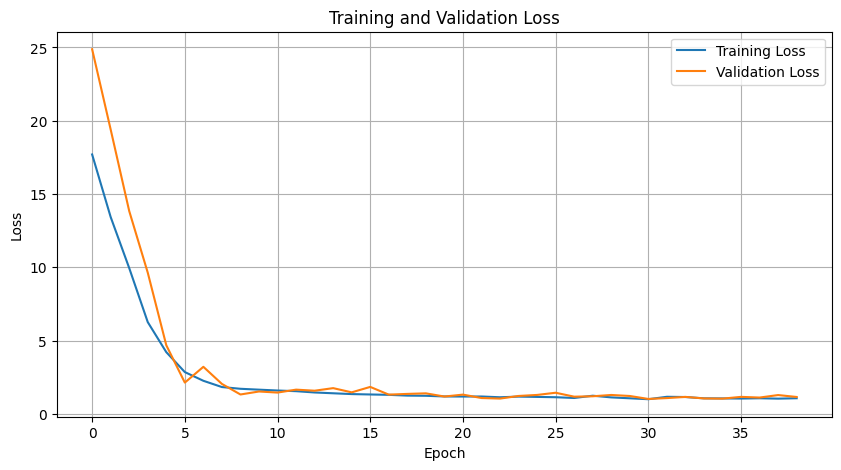

Model saved to 'v4_CNN_1fps.pth'

=== Testing model for 1fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 1fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.2368 degrees²
MAE: 0.6460 degrees
Predictions within 1°: 82.2%
Predictions within 3°: 96.7%
Predictions within 5°: 99.6%


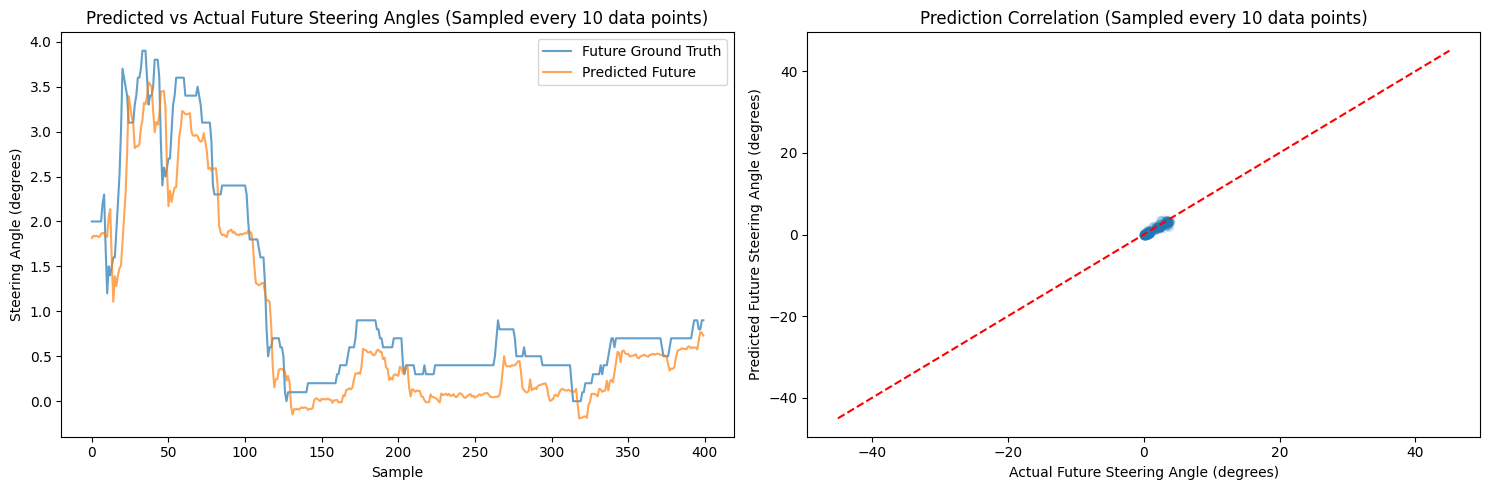


Final results for this fps:
{'mse': 1.2367862462997437, 'mae': 0.6459618210792542, 'within_1_deg': 82.24239164024677, 'within_3_deg': 96.73118082659006, 'within_5_deg': 99.62916757276442, 'frames_before': 10701, 'frames_after': 10701}


In [ ]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 1  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 2fps model ===

=== Training model for 2fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_2fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, skipping: /mn

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:13<00:00,  1.22it/s, loss=7.226, gpu_mem=0.4GB]


Epoch 1: Train Loss: 19.7410, Val Loss: 21.0001


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=6.131, gpu_mem=0.4GB]


Epoch 2: Train Loss: 15.3798, Val Loss: 15.1068


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.82it/s, loss=6.929, gpu_mem=0.4GB]


Epoch 3: Train Loss: 11.8339, Val Loss: 10.4206


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=4.630, gpu_mem=0.4GB]


Epoch 4: Train Loss: 9.2772, Val Loss: 8.1217


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=2.248, gpu_mem=0.4GB]


Epoch 5: Train Loss: 6.9036, Val Loss: 5.1376


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.92it/s, loss=2.439, gpu_mem=0.4GB]


Epoch 6: Train Loss: 5.0602, Val Loss: 6.3606


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=1.584, gpu_mem=0.4GB]


Epoch 7: Train Loss: 4.1387, Val Loss: 3.9786


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=1.322, gpu_mem=0.4GB]


Epoch 8: Train Loss: 3.1246, Val Loss: 1.8162


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.783, gpu_mem=0.4GB]


Epoch 9: Train Loss: 2.4641, Val Loss: 1.8404


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.831, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.9225, Val Loss: 1.1571


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=1.054, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.9564, Val Loss: 1.1996


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.673, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.8375, Val Loss: 1.2975


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.84it/s, loss=1.108, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.7693, Val Loss: 1.2301


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.673, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.5007, Val Loss: 0.8350


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.883, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3945, Val Loss: 0.8605


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.99it/s, loss=0.513, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.5432, Val Loss: 0.9095


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.639, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.4058, Val Loss: 0.8587


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.26it/s, loss=0.814, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.3259, Val Loss: 0.8541


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.728, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.2278, Val Loss: 0.8352


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.90it/s, loss=0.515, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.3106, Val Loss: 0.9034


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=0.538, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.4305, Val Loss: 1.4273


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.789, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2878, Val Loss: 0.8958
Early stopping triggered at epoch 22
Loaded best model from checkpoint


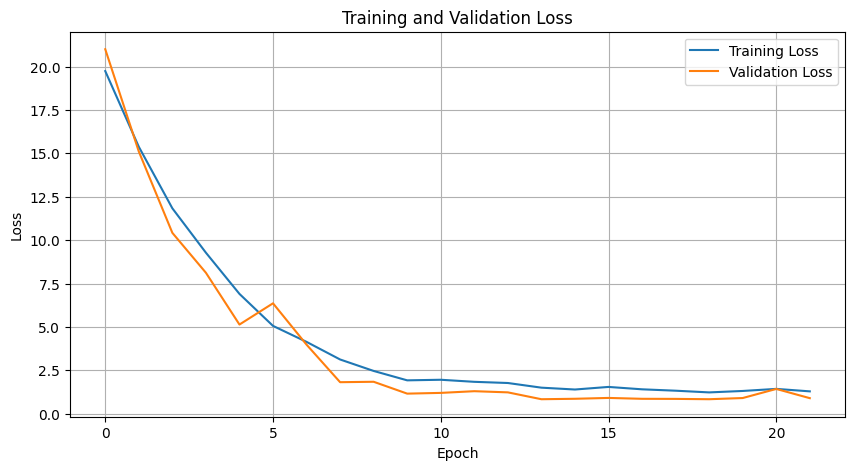

Model saved to 'v4_CNN_2fps.pth'

=== Testing model for 2fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 2fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.5283 degrees²
MAE: 0.7737 degrees
Predictions within 1°: 78.6%
Predictions within 3°: 96.4%
Predictions within 5°: 98.1%


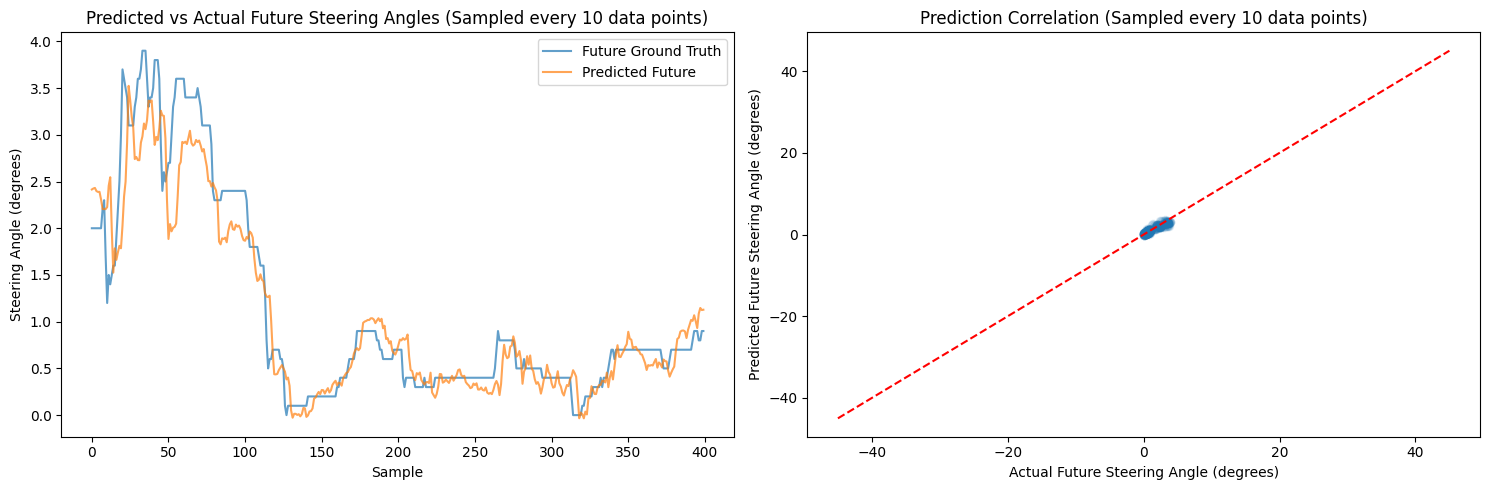

In [87]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 2  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 4fps model ===

=== Training model for 4fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_4fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, skipping: /mn

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:15<00:00,  1.10it/s, loss=7.324, gpu_mem=0.4GB]


Epoch 1: Train Loss: 18.5956, Val Loss: 18.4713


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=4.953, gpu_mem=0.4GB]


Epoch 2: Train Loss: 13.8914, Val Loss: 12.2022


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.14it/s, loss=4.119, gpu_mem=0.4GB]


Epoch 3: Train Loss: 10.1044, Val Loss: 7.5161


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=3.208, gpu_mem=0.4GB]


Epoch 4: Train Loss: 7.0732, Val Loss: 6.9749


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.71it/s, loss=2.441, gpu_mem=0.4GB]


Epoch 5: Train Loss: 4.7885, Val Loss: 5.6892


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.21it/s, loss=1.340, gpu_mem=0.4GB]


Epoch 6: Train Loss: 3.2728, Val Loss: 2.1146


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=1.229, gpu_mem=0.4GB]


Epoch 7: Train Loss: 2.3751, Val Loss: 1.6941


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.71it/s, loss=1.402, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.9228, Val Loss: 1.4659


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.708, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.7681, Val Loss: 1.2221


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.593, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.6039, Val Loss: 1.0839


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.95it/s, loss=0.763, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.4982, Val Loss: 1.1424


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.813, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.5715, Val Loss: 1.5116


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.756, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.5727, Val Loss: 1.0344


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.707, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.4280, Val Loss: 1.0987


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=0.687, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.2413, Val Loss: 0.9915


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.896, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.3235, Val Loss: 0.9112


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.619, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.3617, Val Loss: 1.0942


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=0.596, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.3100, Val Loss: 0.9285


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.595, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3313, Val Loss: 0.8852


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.866, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.3373, Val Loss: 1.0376


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s, loss=0.622, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.2864, Val Loss: 0.9332


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.512, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2776, Val Loss: 0.9622


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.611, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.3197, Val Loss: 0.8878


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.35it/s, loss=0.488, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.2222, Val Loss: 0.9664


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.805, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.2774, Val Loss: 0.9190


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.591, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1971, Val Loss: 0.8683


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.424, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.1017, Val Loss: 0.8847


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.88it/s, loss=0.500, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.2108, Val Loss: 0.7946


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.581, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.1623, Val Loss: 0.9077


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.784, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1799, Val Loss: 0.8780


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.83it/s, loss=0.606, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1124, Val Loss: 0.8161


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=0.473, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1633, Val Loss: 0.8405


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.525, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1156, Val Loss: 0.9595


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.586, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.2234, Val Loss: 0.8804


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.421, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.1692, Val Loss: 0.8271


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.623, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.2331, Val Loss: 0.8506
Early stopping triggered at epoch 36
Loaded best model from checkpoint


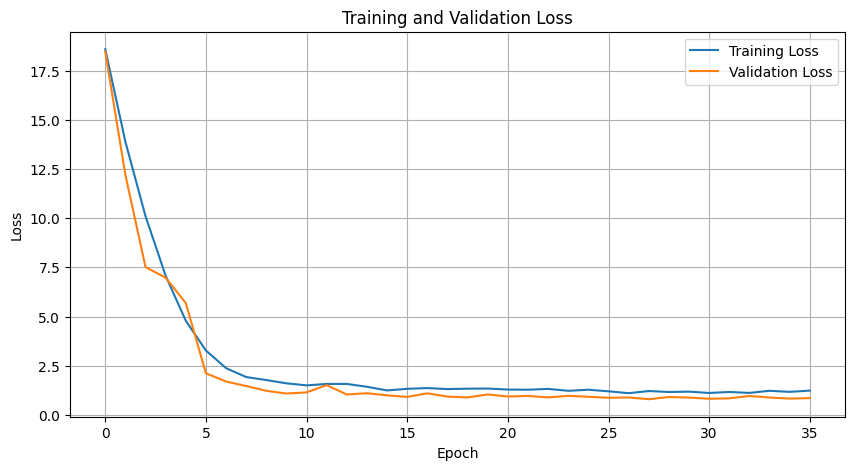

Model saved to 'v4_CNN_4fps.pth'

=== Testing model for 4fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 4fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.4453 degrees²
MAE: 0.6862 degrees
Predictions within 1°: 81.6%
Predictions within 3°: 96.6%
Predictions within 5°: 98.3%


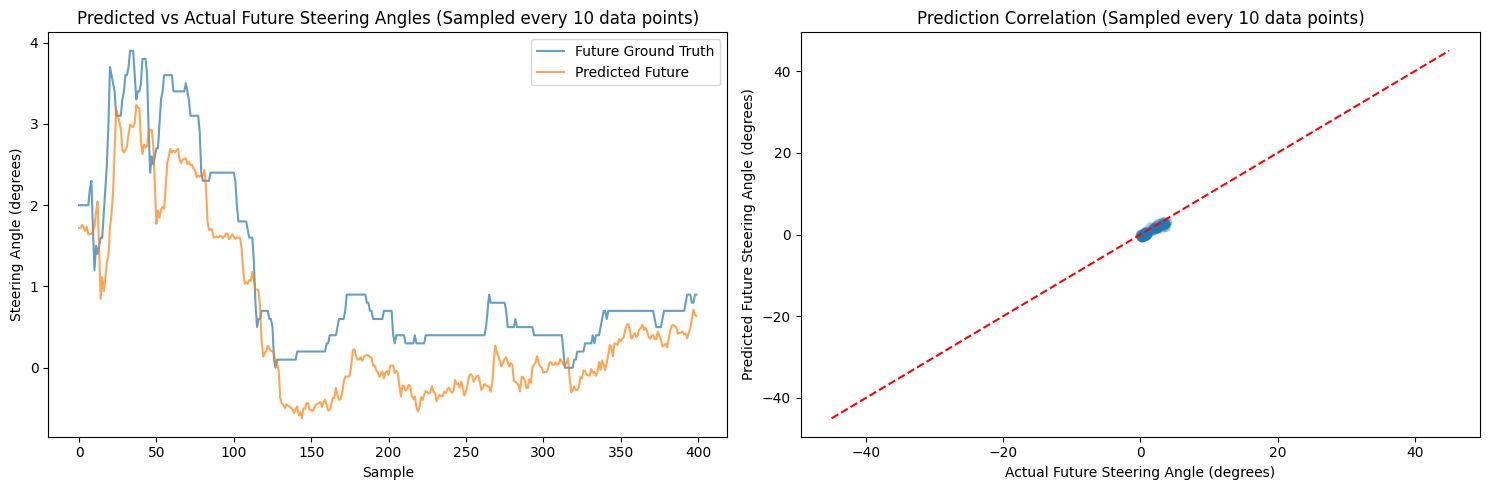

In [89]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 4  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 6fps model ===

=== Training model for 6fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_6fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, skipping: /mn

Epoch 1/50: 100%|███████████████████████████████████████████| 17/17 [00:14<00:00,  1.17it/s, loss=11.858, gpu_mem=0.4GB]


Epoch 1: Train Loss: 18.5136, Val Loss: 17.3651


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.54it/s, loss=4.599, gpu_mem=0.4GB]


Epoch 2: Train Loss: 13.3934, Val Loss: 11.1512


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=2.969, gpu_mem=0.4GB]


Epoch 3: Train Loss: 8.7444, Val Loss: 5.6661


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=1.591, gpu_mem=0.4GB]


Epoch 4: Train Loss: 4.6001, Val Loss: 4.1995


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  3.12it/s, loss=0.912, gpu_mem=0.4GB]


Epoch 5: Train Loss: 2.9108, Val Loss: 1.7290


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.922, gpu_mem=0.4GB]


Epoch 6: Train Loss: 2.2300, Val Loss: 1.2921


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.822, gpu_mem=0.4GB]


Epoch 7: Train Loss: 1.8204, Val Loss: 1.3085


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.634, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.7216, Val Loss: 1.4846


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.53it/s, loss=0.587, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.5736, Val Loss: 0.9534


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.551, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.4320, Val Loss: 0.9746


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.697, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.3789, Val Loss: 1.2976


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.89it/s, loss=0.747, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.3285, Val Loss: 0.9306


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.403, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.3243, Val Loss: 0.8653


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.642, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.2764, Val Loss: 0.9069


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.82it/s, loss=0.834, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3041, Val Loss: 0.9638


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.55it/s, loss=0.793, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.1890, Val Loss: 0.9500


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=0.481, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.1615, Val Loss: 1.0508


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.685, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.2962, Val Loss: 0.8993


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.583, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.2096, Val Loss: 0.8557


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.511, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.2427, Val Loss: 0.9832


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.455, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.1502, Val Loss: 0.9728


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.98it/s, loss=0.887, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2174, Val Loss: 0.8883


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.503, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.1872, Val Loss: 0.8507


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=0.389, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.2331, Val Loss: 0.8746


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.54it/s, loss=0.787, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.0973, Val Loss: 0.8659


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.984, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.2355, Val Loss: 0.8381


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.564, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.0804, Val Loss: 0.9677


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.620, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.1696, Val Loss: 0.8777


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.87it/s, loss=0.907, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.1246, Val Loss: 0.8401


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.53it/s, loss=0.655, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1196, Val Loss: 0.8825


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.55it/s, loss=0.492, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1192, Val Loss: 0.9409


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.12it/s, loss=0.364, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1344, Val Loss: 0.8595


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.545, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.2239, Val Loss: 0.9613


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.584, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.0822, Val Loss: 0.9193
Early stopping triggered at epoch 34
Loaded best model from checkpoint


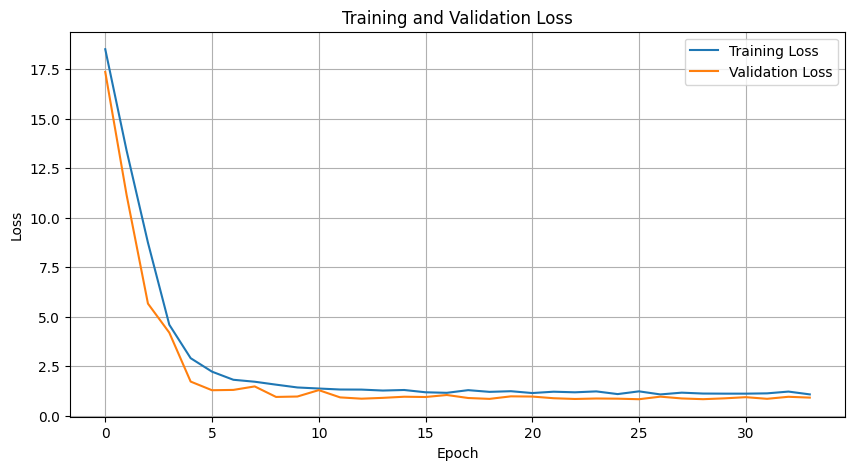

Model saved to 'v4_CNN_6fps.pth'

=== Testing model for 6fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 6fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.7176 degrees²
MAE: 0.6923 degrees
Predictions within 1°: 81.8%
Predictions within 3°: 96.5%
Predictions within 5°: 98.7%


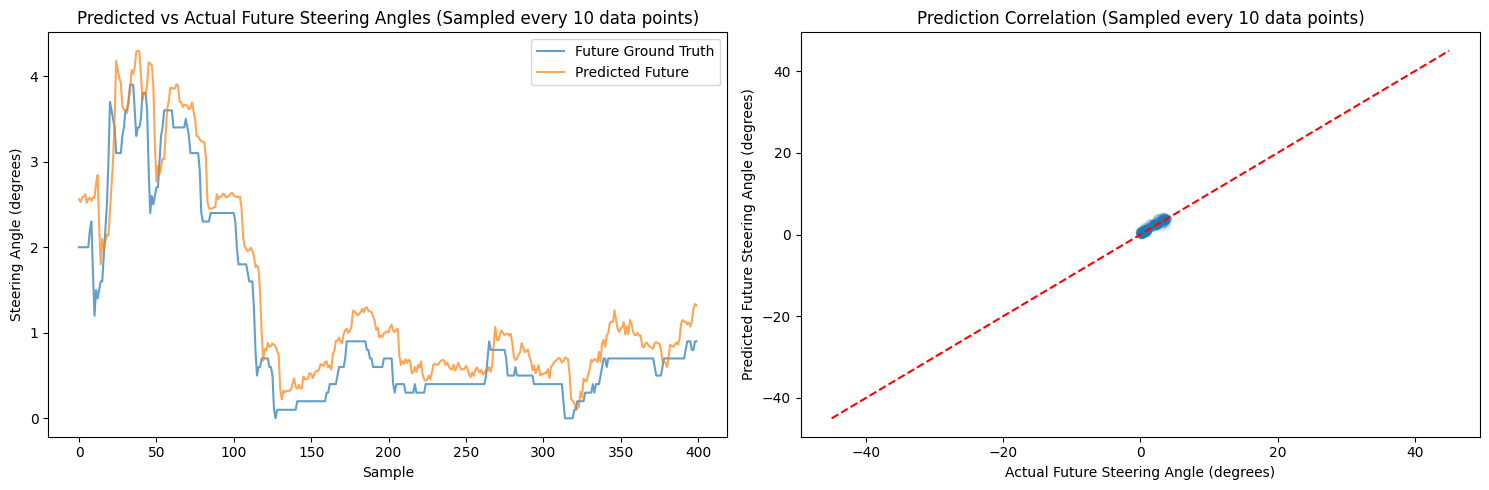

In [90]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 6  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 8fps model ===

=== Training model for 8fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_8fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, skipping: /mn

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:14<00:00,  1.21it/s, loss=8.063, gpu_mem=0.4GB]


Epoch 1: Train Loss: 19.1007, Val Loss: 23.8722


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=6.307, gpu_mem=0.4GB]


Epoch 2: Train Loss: 14.8612, Val Loss: 16.9945


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=4.456, gpu_mem=0.4GB]


Epoch 3: Train Loss: 11.5767, Val Loss: 12.4848


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=3.258, gpu_mem=0.4GB]


Epoch 4: Train Loss: 8.7728, Val Loss: 9.0646


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.76it/s, loss=2.339, gpu_mem=0.4GB]


Epoch 5: Train Loss: 6.2057, Val Loss: 10.4731


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=2.147, gpu_mem=0.4GB]


Epoch 6: Train Loss: 4.4710, Val Loss: 4.2784


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=1.065, gpu_mem=0.4GB]


Epoch 7: Train Loss: 2.9981, Val Loss: 2.6894


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=1.286, gpu_mem=0.4GB]


Epoch 8: Train Loss: 2.3945, Val Loss: 2.1138


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=0.855, gpu_mem=0.4GB]


Epoch 9: Train Loss: 2.0651, Val Loss: 2.9072


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.937, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.7913, Val Loss: 1.7280


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=1.437, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.6634, Val Loss: 2.0868


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.839, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.5369, Val Loss: 1.5641


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.808, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.4486, Val Loss: 1.2550


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=1.103, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.4325, Val Loss: 1.3444


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.62it/s, loss=0.657, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3683, Val Loss: 1.3000


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.862, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.3608, Val Loss: 1.1032


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.859, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.3045, Val Loss: 0.9428


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.87it/s, loss=0.892, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.1929, Val Loss: 0.9639


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=1.048, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3272, Val Loss: 0.9412


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.602, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.2893, Val Loss: 0.9796


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.76it/s, loss=0.694, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.2309, Val Loss: 0.9113


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.705, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.1184, Val Loss: 0.8608


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.530, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.1864, Val Loss: 1.0472


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.614, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.1031, Val Loss: 1.1762


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.88it/s, loss=0.426, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.1528, Val Loss: 0.9131


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.807, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1384, Val Loss: 0.8138


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.26it/s, loss=0.660, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.1391, Val Loss: 0.8510


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.76it/s, loss=0.774, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.1025, Val Loss: 0.8012


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.455, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.0862, Val Loss: 0.9618


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.816, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1287, Val Loss: 0.9906


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=0.658, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.0854, Val Loss: 0.8697


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.683, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1557, Val Loss: 0.8662


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.594, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1647, Val Loss: 0.9247


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.445, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.0984, Val Loss: 0.8308


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.43it/s, loss=1.034, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.0213, Val Loss: 0.8804


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.936, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.1370, Val Loss: 0.9854
Early stopping triggered at epoch 36
Loaded best model from checkpoint


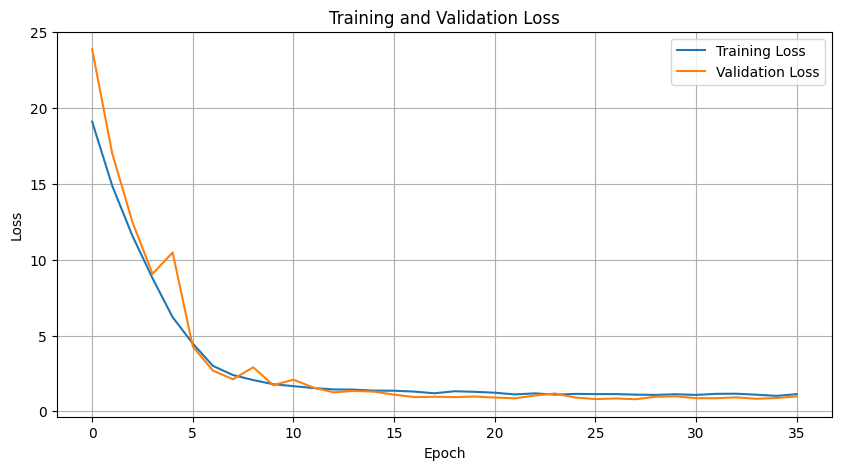

Model saved to 'v4_CNN_8fps.pth'

=== Testing model for 8fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 8fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.5482 degrees²
MAE: 0.7316 degrees
Predictions within 1°: 80.7%
Predictions within 3°: 96.4%
Predictions within 5°: 98.3%


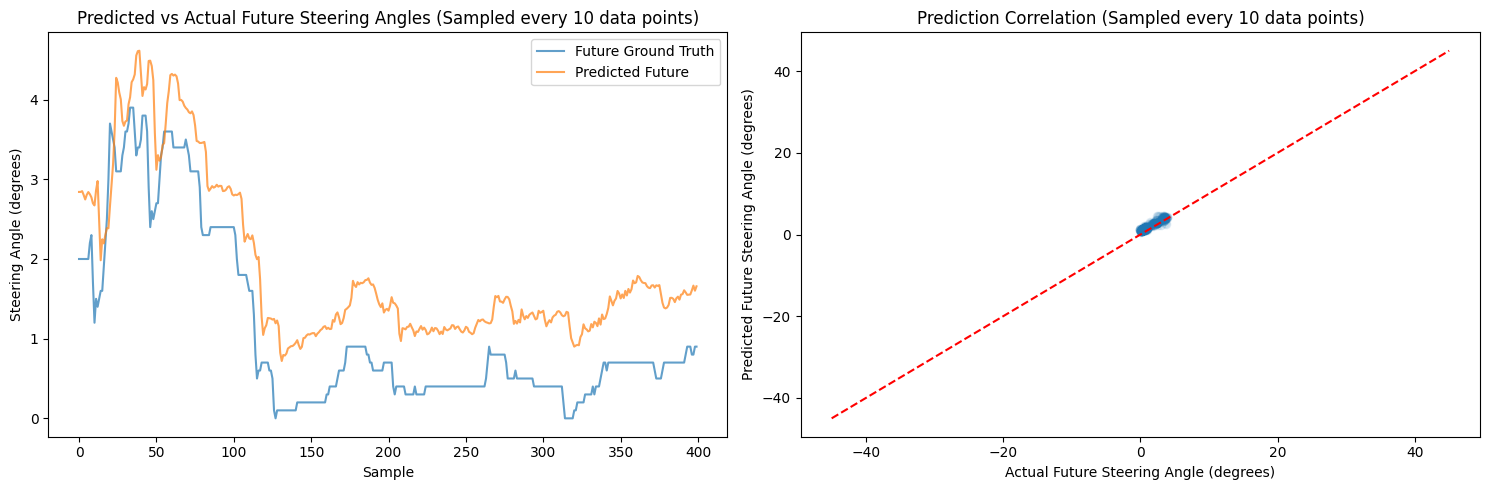

In [91]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 8  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 10fps model ===

=== Training model for 10fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_10fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:14<00:00,  1.17it/s, loss=6.006, gpu_mem=0.4GB]


Epoch 1: Train Loss: 18.7988, Val Loss: 19.3803


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=7.590, gpu_mem=0.4GB]


Epoch 2: Train Loss: 14.4954, Val Loss: 13.7494


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=3.727, gpu_mem=0.4GB]


Epoch 3: Train Loss: 11.5257, Val Loss: 9.6530


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=2.983, gpu_mem=0.4GB]


Epoch 4: Train Loss: 8.6137, Val Loss: 7.3979


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.92it/s, loss=2.246, gpu_mem=0.4GB]


Epoch 5: Train Loss: 5.9032, Val Loss: 5.5027


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=2.043, gpu_mem=0.4GB]


Epoch 6: Train Loss: 4.3846, Val Loss: 4.0579


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=1.321, gpu_mem=0.4GB]


Epoch 7: Train Loss: 3.2862, Val Loss: 2.9540


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  3.09it/s, loss=1.178, gpu_mem=0.4GB]


Epoch 8: Train Loss: 2.3205, Val Loss: 1.7575


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.993, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.8928, Val Loss: 2.1110


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.653, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.6946, Val Loss: 1.4197


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.802, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.6671, Val Loss: 1.3050


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=1.023, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.5570, Val Loss: 1.2050


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.778, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.4286, Val Loss: 1.2194


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=1.028, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.4965, Val Loss: 1.2946


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.92it/s, loss=0.984, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.4151, Val Loss: 1.3508


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.601, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.4356, Val Loss: 1.2527


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=1.251, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.3635, Val Loss: 1.1223


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=0.915, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.3332, Val Loss: 1.2099


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.611, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3567, Val Loss: 1.3440


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=1.237, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.4079, Val Loss: 1.2094


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.715, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.3147, Val Loss: 1.3431


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.794, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2813, Val Loss: 1.1400


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.12it/s, loss=0.633, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.2604, Val Loss: 1.1473


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=1.226, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.3014, Val Loss: 1.1970


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.06it/s, loss=0.742, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.2329, Val Loss: 1.0985


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.639, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1868, Val Loss: 1.0645


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.854, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.3391, Val Loss: 1.3245


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.97it/s, loss=0.622, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.2951, Val Loss: 1.2317


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.15it/s, loss=0.721, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.2709, Val Loss: 1.1340


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.714, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.2310, Val Loss: 1.0895


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.616, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1448, Val Loss: 1.2447


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.568, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1282, Val Loss: 1.0369


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.453, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1568, Val Loss: 1.0754


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.424, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.2616, Val Loss: 1.0470


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s, loss=0.473, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.1078, Val Loss: 1.0914


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.957, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.1357, Val Loss: 0.9995


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.861, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.1962, Val Loss: 0.9743


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.93it/s, loss=0.527, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.0750, Val Loss: 1.0937


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.21it/s, loss=0.683, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.1471, Val Loss: 1.0561


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.691, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.1625, Val Loss: 0.9615


Epoch 41/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.486, gpu_mem=0.4GB]


Epoch 41: Train Loss: 1.1007, Val Loss: 1.0622


Epoch 42/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.743, gpu_mem=0.4GB]


Epoch 42: Train Loss: 1.1215, Val Loss: 0.9564


Epoch 43/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=0.869, gpu_mem=0.4GB]


Epoch 43: Train Loss: 1.1071, Val Loss: 1.0006


Epoch 44/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.642, gpu_mem=0.4GB]


Epoch 44: Train Loss: 1.1301, Val Loss: 0.9945


Epoch 45/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.09it/s, loss=0.678, gpu_mem=0.4GB]


Epoch 45: Train Loss: 1.0905, Val Loss: 0.9883


Epoch 46/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=0.472, gpu_mem=0.4GB]


Epoch 46: Train Loss: 0.9784, Val Loss: 1.0233


Epoch 47/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.474, gpu_mem=0.4GB]


Epoch 47: Train Loss: 1.0436, Val Loss: 1.0476


Epoch 48/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.98it/s, loss=0.599, gpu_mem=0.4GB]


Epoch 48: Train Loss: 1.1201, Val Loss: 1.0575


Epoch 49/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.519, gpu_mem=0.4GB]


Epoch 49: Train Loss: 0.9508, Val Loss: 1.0179


Epoch 50/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.610, gpu_mem=0.4GB]


Epoch 50: Train Loss: 1.1429, Val Loss: 1.0983
Early stopping triggered at epoch 50
Loaded best model from checkpoint


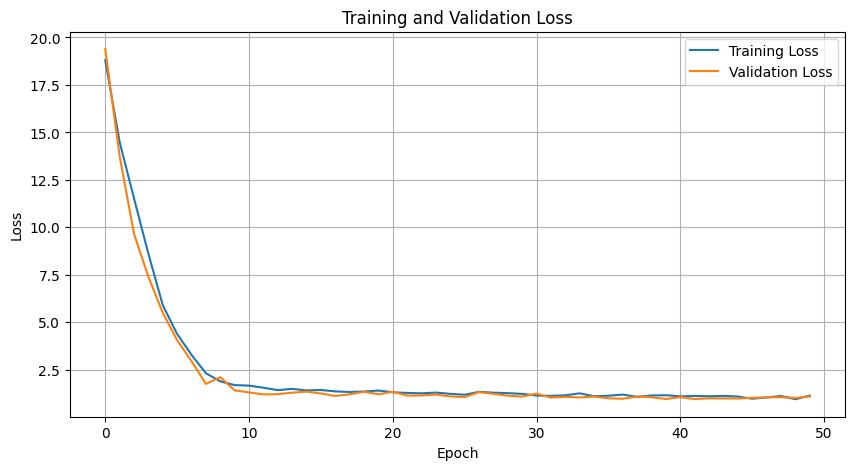

Model saved to 'v4_CNN_10fps.pth'

=== Testing model for 10fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 10fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.4749 degrees²
MAE: 0.7551 degrees
Predictions within 1°: 79.5%
Predictions within 3°: 96.6%
Predictions within 5°: 98.3%


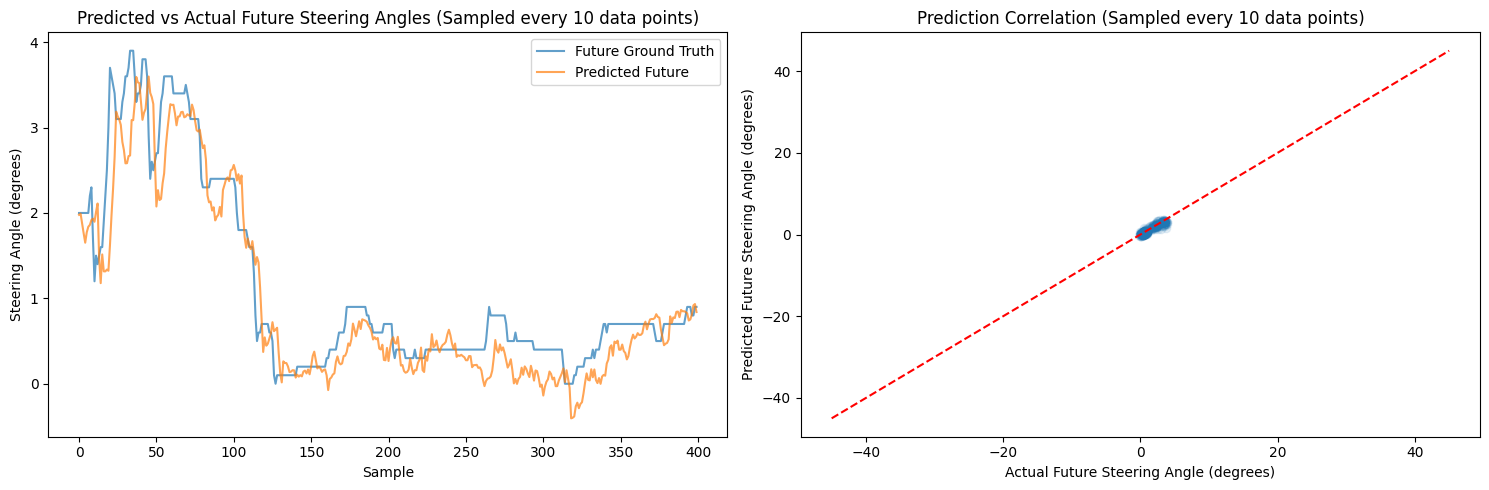

In [99]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 10  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 12fps model ===

=== Training model for 12fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_12fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:14<00:00,  1.16it/s, loss=8.592, gpu_mem=0.4GB]


Epoch 1: Train Loss: 20.1858, Val Loss: 18.9741


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=8.361, gpu_mem=0.4GB]


Epoch 2: Train Loss: 15.7770, Val Loss: 13.5839


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=4.970, gpu_mem=0.4GB]


Epoch 3: Train Loss: 12.3581, Val Loss: 10.3807


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=2.116, gpu_mem=0.4GB]


Epoch 4: Train Loss: 7.6262, Val Loss: 6.1003


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.90it/s, loss=2.089, gpu_mem=0.4GB]


Epoch 5: Train Loss: 3.6611, Val Loss: 2.2208


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.55it/s, loss=0.779, gpu_mem=0.4GB]


Epoch 6: Train Loss: 2.1364, Val Loss: 1.4294


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=1.201, gpu_mem=0.4GB]


Epoch 7: Train Loss: 1.8014, Val Loss: 1.6767


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.81it/s, loss=0.860, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.7384, Val Loss: 1.5189


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=1.107, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.7820, Val Loss: 1.3748


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=1.119, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.7154, Val Loss: 0.9878


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=0.910, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.6109, Val Loss: 0.9829


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.592, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.4865, Val Loss: 1.0529


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.747, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.3879, Val Loss: 1.0011


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=0.998, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.4903, Val Loss: 1.1294


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.861, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3764, Val Loss: 1.0803


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.635, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.4338, Val Loss: 0.9502


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.579, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.3522, Val Loss: 1.1960


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.84it/s, loss=0.643, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.4572, Val Loss: 0.9864


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.606, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3558, Val Loss: 0.9233


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.734, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.3150, Val Loss: 0.9192


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.97it/s, loss=0.684, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.3617, Val Loss: 0.9381


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.705, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2065, Val Loss: 0.8393


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.971, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.3008, Val Loss: 1.0678


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=0.418, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.2417, Val Loss: 0.9232


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=1.072, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.2691, Val Loss: 0.8505


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.840, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.2199, Val Loss: 0.9091


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=0.674, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.3462, Val Loss: 0.8407


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.94it/s, loss=0.707, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.1831, Val Loss: 0.9335


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.660, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.2404, Val Loss: 0.8150


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.43it/s, loss=0.458, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1910, Val Loss: 0.8893


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.83it/s, loss=0.761, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.0923, Val Loss: 0.8846


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.583, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1380, Val Loss: 0.7909


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=0.553, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.3041, Val Loss: 0.9255


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.613, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.1469, Val Loss: 1.0032


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.632, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.1437, Val Loss: 0.8817


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=0.848, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.2157, Val Loss: 0.8892


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.609, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.2474, Val Loss: 0.9483


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=0.777, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.1975, Val Loss: 0.9033


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.534, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.1508, Val Loss: 0.8454


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.373, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.1387, Val Loss: 0.8926
Early stopping triggered at epoch 40
Loaded best model from checkpoint


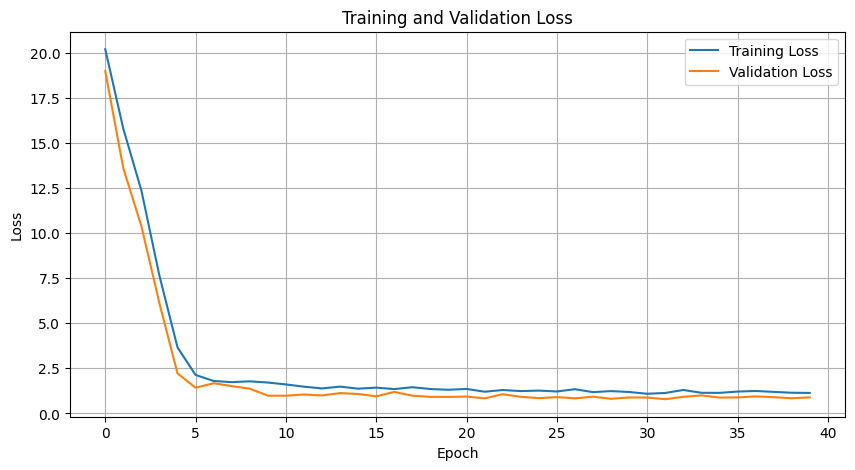

Model saved to 'v4_CNN_12fps.pth'

=== Testing model for 12fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 12fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.5715 degrees²
MAE: 0.7003 degrees
Predictions within 1°: 80.2%
Predictions within 3°: 96.3%
Predictions within 5°: 99.5%


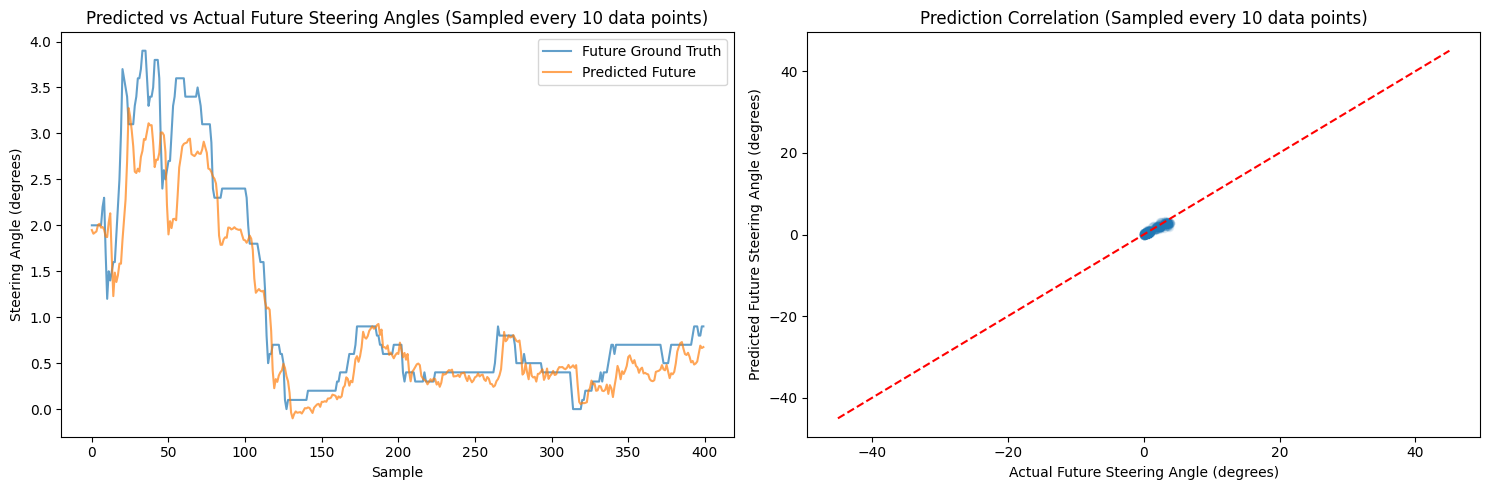

In [93]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 12  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 14fps model ===

=== Training model for 14fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_14fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:13<00:00,  1.28it/s, loss=8.166, gpu_mem=0.4GB]


Epoch 1: Train Loss: 18.9828, Val Loss: 19.3450


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=8.619, gpu_mem=0.4GB]


Epoch 2: Train Loss: 14.7983, Val Loss: 14.1006


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=4.460, gpu_mem=0.4GB]


Epoch 3: Train Loss: 11.2389, Val Loss: 9.8858


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  3.04it/s, loss=4.231, gpu_mem=0.4GB]


Epoch 4: Train Loss: 8.3531, Val Loss: 7.9913


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=2.823, gpu_mem=0.4GB]


Epoch 5: Train Loss: 6.1522, Val Loss: 5.3084


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.20it/s, loss=2.183, gpu_mem=0.4GB]


Epoch 6: Train Loss: 4.8695, Val Loss: 4.5369


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=1.396, gpu_mem=0.4GB]


Epoch 7: Train Loss: 3.9087, Val Loss: 4.4797


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s, loss=1.391, gpu_mem=0.4GB]


Epoch 8: Train Loss: 3.0478, Val Loss: 2.4982


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.18it/s, loss=1.112, gpu_mem=0.4GB]


Epoch 9: Train Loss: 2.5113, Val Loss: 2.2126


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.905, gpu_mem=0.4GB]


Epoch 10: Train Loss: 2.1100, Val Loss: 2.0594


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.07it/s, loss=1.154, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.9974, Val Loss: 1.6600


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=1.229, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.8694, Val Loss: 1.8795


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=0.658, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.6733, Val Loss: 1.4970


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.99it/s, loss=0.965, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.6553, Val Loss: 1.7309


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.622, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.5456, Val Loss: 1.5035


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.718, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.4716, Val Loss: 1.3201


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.98it/s, loss=0.832, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.4292, Val Loss: 1.3883


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.774, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.4390, Val Loss: 1.4201


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.35it/s, loss=0.569, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3449, Val Loss: 1.5430


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=1.001, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.3200, Val Loss: 1.1769


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.03it/s, loss=0.671, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.2861, Val Loss: 1.4636


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s, loss=0.563, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.3662, Val Loss: 1.1795


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.18it/s, loss=0.488, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.2821, Val Loss: 1.1306


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=0.715, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.2421, Val Loss: 1.2139


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.816, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.2013, Val Loss: 1.2566


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.23it/s, loss=0.406, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.3272, Val Loss: 1.2262


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=0.627, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.2977, Val Loss: 1.1554


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.535, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.3108, Val Loss: 1.1119


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.514, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.1433, Val Loss: 1.1558


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.729, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1139, Val Loss: 1.2042


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.08it/s, loss=0.903, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1531, Val Loss: 1.1961


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.54it/s, loss=0.491, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.2053, Val Loss: 1.0809


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.714, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1930, Val Loss: 1.0873


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.07it/s, loss=0.457, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.2315, Val Loss: 1.1633


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.534, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.2261, Val Loss: 1.1029


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.695, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.1452, Val Loss: 1.1261


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.631, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.1967, Val Loss: 1.3452


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.440, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.2475, Val Loss: 1.2381


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.815, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.0790, Val Loss: 1.0584


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.23it/s, loss=0.770, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.1558, Val Loss: 1.1936


Epoch 41/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.21it/s, loss=1.026, gpu_mem=0.4GB]


Epoch 41: Train Loss: 1.1457, Val Loss: 1.3546


Epoch 42/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.811, gpu_mem=0.4GB]


Epoch 42: Train Loss: 1.1544, Val Loss: 1.1685


Epoch 43/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.50it/s, loss=0.510, gpu_mem=0.4GB]


Epoch 43: Train Loss: 1.0817, Val Loss: 1.0952


Epoch 44/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s, loss=0.574, gpu_mem=0.4GB]


Epoch 44: Train Loss: 1.1475, Val Loss: 1.0196


Epoch 45/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.605, gpu_mem=0.4GB]


Epoch 45: Train Loss: 1.1262, Val Loss: 1.1499


Epoch 46/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=0.406, gpu_mem=0.4GB]


Epoch 46: Train Loss: 1.0629, Val Loss: 1.1241


Epoch 47/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.400, gpu_mem=0.4GB]


Epoch 47: Train Loss: 1.1172, Val Loss: 1.0965


Epoch 48/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.534, gpu_mem=0.4GB]


Epoch 48: Train Loss: 1.1311, Val Loss: 1.0008


Epoch 49/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.663, gpu_mem=0.4GB]


Epoch 49: Train Loss: 0.9948, Val Loss: 1.2088


Epoch 50/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.398, gpu_mem=0.4GB]


Epoch 50: Train Loss: 0.9067, Val Loss: 1.0470
Loaded best model from checkpoint


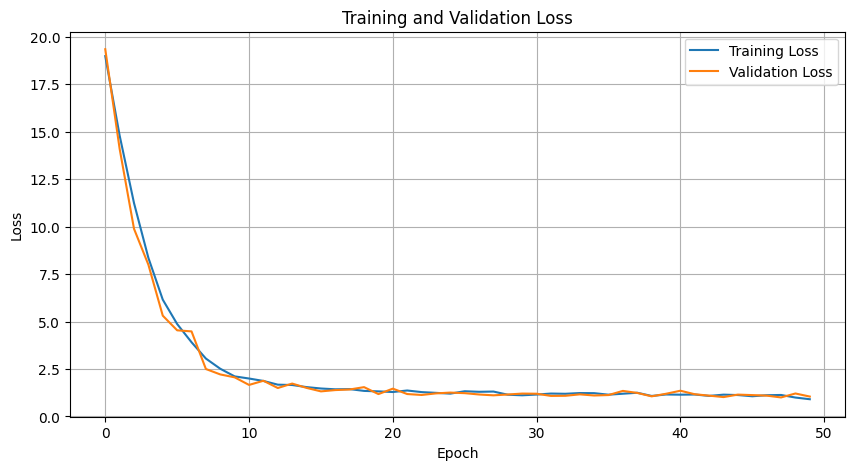

Model saved to 'v4_CNN_14fps.pth'

=== Testing model for 14fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 14fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.7479 degrees²
MAE: 0.7195 degrees
Predictions within 1°: 79.7%
Predictions within 3°: 95.4%
Predictions within 5°: 98.0%


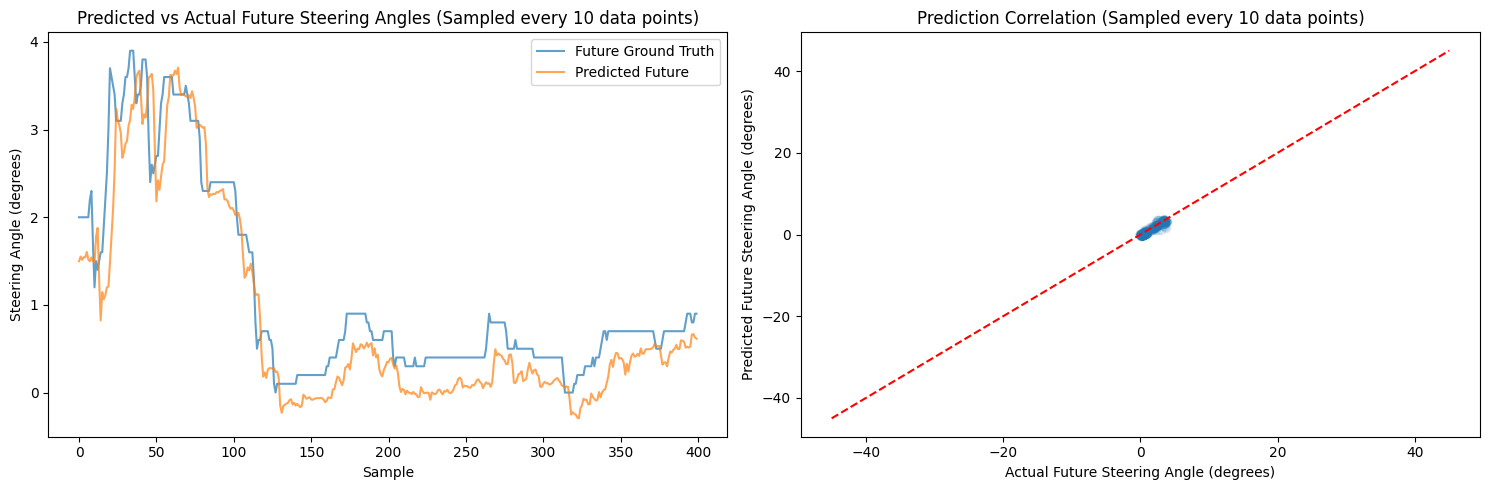

In [94]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 14  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 16fps model ===

=== Training model for 16fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_16fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|███████████████████████████████████████████| 17/17 [00:14<00:00,  1.20it/s, loss=11.025, gpu_mem=0.4GB]


Epoch 1: Train Loss: 19.1161, Val Loss: 21.4889


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=7.102, gpu_mem=0.4GB]


Epoch 2: Train Loss: 14.2218, Val Loss: 15.2447


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.88it/s, loss=3.986, gpu_mem=0.4GB]


Epoch 3: Train Loss: 9.9160, Val Loss: 11.3767


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=1.338, gpu_mem=0.4GB]


Epoch 4: Train Loss: 6.3266, Val Loss: 5.5455


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=1.443, gpu_mem=0.4GB]


Epoch 5: Train Loss: 3.6249, Val Loss: 3.0747


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=1.444, gpu_mem=0.4GB]


Epoch 6: Train Loss: 2.6999, Val Loss: 5.5048


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.865, gpu_mem=0.4GB]


Epoch 7: Train Loss: 1.9872, Val Loss: 1.7691


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.23it/s, loss=0.657, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.7214, Val Loss: 1.5143


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=0.722, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.6502, Val Loss: 1.3259


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.607, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.5523, Val Loss: 1.2862


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.500, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.4628, Val Loss: 1.4852


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.744, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.5205, Val Loss: 1.6766


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.489, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.5801, Val Loss: 1.3823


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.719, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.3613, Val Loss: 1.3158


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.12it/s, loss=0.553, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.3024, Val Loss: 1.3962


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.85it/s, loss=0.570, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.2195, Val Loss: 1.3094


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.580, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.3133, Val Loss: 1.0798


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.781, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.2607, Val Loss: 1.1238


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.98it/s, loss=0.838, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3132, Val Loss: 1.2950


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.643, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.2195, Val Loss: 1.0937


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.616, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.2249, Val Loss: 1.1503


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.13it/s, loss=0.837, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.2615, Val Loss: 1.0792


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=0.665, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.1907, Val Loss: 1.0996


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=1.177, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.3493, Val Loss: 1.0979


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=0.519, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.1975, Val Loss: 1.0715


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.99it/s, loss=0.597, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1993, Val Loss: 1.1006


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.671, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.1998, Val Loss: 1.0855


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.446, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.1915, Val Loss: 1.0506


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.89it/s, loss=0.723, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.2189, Val Loss: 0.9985


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.416, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1955, Val Loss: 1.0535


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.608, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1706, Val Loss: 1.0762


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.09it/s, loss=0.945, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.0925, Val Loss: 1.0795


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.487, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.1315, Val Loss: 0.9885


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.797, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.1321, Val Loss: 1.0245


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.689, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.0718, Val Loss: 0.9560


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.713, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.1592, Val Loss: 1.0914


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.525, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.2108, Val Loss: 1.0017


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.20it/s, loss=0.888, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.1850, Val Loss: 1.0963


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.01it/s, loss=0.498, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.1003, Val Loss: 1.1277


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.699, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.1511, Val Loss: 1.0214


Epoch 41/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.35it/s, loss=0.505, gpu_mem=0.4GB]


Epoch 41: Train Loss: 1.0695, Val Loss: 0.9781


Epoch 42/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.01it/s, loss=0.499, gpu_mem=0.4GB]


Epoch 42: Train Loss: 1.0563, Val Loss: 1.0536


Epoch 43/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.460, gpu_mem=0.4GB]


Epoch 43: Train Loss: 1.1039, Val Loss: 1.0907
Early stopping triggered at epoch 43
Loaded best model from checkpoint


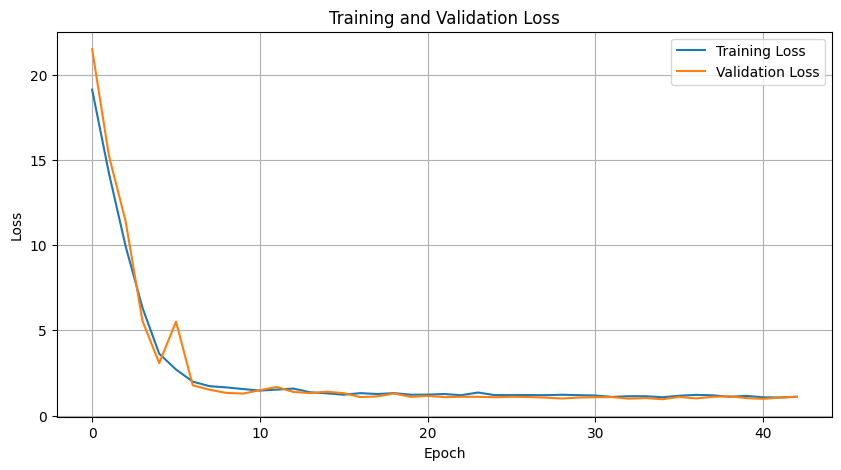

Model saved to 'v4_CNN_16fps.pth'

=== Testing model for 16fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 16fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.4204 degrees²
MAE: 0.7139 degrees
Predictions within 1°: 80.2%
Predictions within 3°: 96.4%
Predictions within 5°: 99.5%


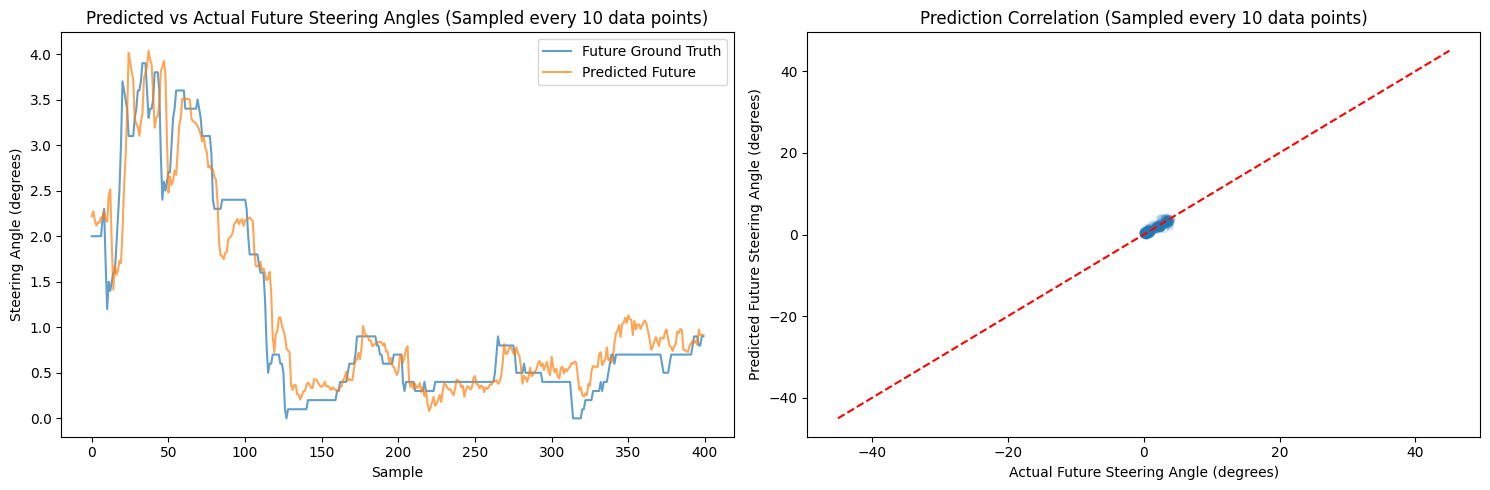

In [101]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 16  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 18fps model ===

=== Training model for 18fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_18fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:13<00:00,  1.22it/s, loss=6.545, gpu_mem=0.4GB]


Epoch 1: Train Loss: 18.3024, Val Loss: 16.8841


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=6.356, gpu_mem=0.4GB]


Epoch 2: Train Loss: 13.6060, Val Loss: 11.3225


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.92it/s, loss=5.149, gpu_mem=0.4GB]


Epoch 3: Train Loss: 9.9443, Val Loss: 11.6672


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=4.190, gpu_mem=0.4GB]


Epoch 4: Train Loss: 6.7813, Val Loss: 8.6645


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=2.370, gpu_mem=0.4GB]


Epoch 5: Train Loss: 4.5133, Val Loss: 3.5974


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.85it/s, loss=1.405, gpu_mem=0.4GB]


Epoch 6: Train Loss: 3.1706, Val Loss: 3.1140


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=1.337, gpu_mem=0.4GB]


Epoch 7: Train Loss: 2.7549, Val Loss: 2.0414


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.21it/s, loss=1.776, gpu_mem=0.4GB]


Epoch 8: Train Loss: 2.4341, Val Loss: 2.0064


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.93it/s, loss=1.128, gpu_mem=0.4GB]


Epoch 9: Train Loss: 2.2786, Val Loss: 1.8952


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.902, gpu_mem=0.4GB]


Epoch 10: Train Loss: 2.0164, Val Loss: 1.3326


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.07it/s, loss=0.958, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.9221, Val Loss: 1.3982


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=1.144, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.7268, Val Loss: 1.2782


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.639, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.8052, Val Loss: 1.1393


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.13it/s, loss=0.921, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.7193, Val Loss: 1.4353


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.781, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.6296, Val Loss: 1.0160


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s, loss=0.965, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.5908, Val Loss: 0.9703


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.54it/s, loss=1.434, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.5416, Val Loss: 0.9845


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.22it/s, loss=0.633, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.4172, Val Loss: 1.0096


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=0.609, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.4683, Val Loss: 1.0576


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.694, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.4280, Val Loss: 1.0360


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.11it/s, loss=0.731, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.4043, Val Loss: 1.0273


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.87it/s, loss=0.472, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.4428, Val Loss: 1.0327


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.26it/s, loss=1.042, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.3821, Val Loss: 1.1235


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=0.622, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.2819, Val Loss: 0.8481


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.411, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.2548, Val Loss: 0.8284


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.523, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.2490, Val Loss: 0.8534


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.12it/s, loss=0.571, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.1974, Val Loss: 0.8812


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.916, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.3110, Val Loss: 0.8617


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.697, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.2500, Val Loss: 0.8487


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.628, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.1729, Val Loss: 0.8012


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.859, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.2971, Val Loss: 0.8433


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.86it/s, loss=0.883, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.2010, Val Loss: 0.9903


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.43it/s, loss=0.822, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.2779, Val Loss: 0.7649


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.731, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.1874, Val Loss: 1.4552


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s, loss=0.654, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.1608, Val Loss: 0.7732


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.13it/s, loss=0.568, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.0672, Val Loss: 0.7229


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.24it/s, loss=0.496, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.0556, Val Loss: 0.6770


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.83it/s, loss=0.962, gpu_mem=0.4GB]


Epoch 38: Train Loss: 1.0557, Val Loss: 0.6563


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.459, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.0399, Val Loss: 0.6912


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:08<00:00,  2.11it/s, loss=0.512, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.0639, Val Loss: 0.7084


Epoch 41/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.633, gpu_mem=0.4GB]


Epoch 41: Train Loss: 1.1070, Val Loss: 0.6532


Epoch 42/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.480, gpu_mem=0.4GB]


Epoch 42: Train Loss: 1.1042, Val Loss: 0.7807


Epoch 43/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=0.779, gpu_mem=0.4GB]


Epoch 43: Train Loss: 1.1172, Val Loss: 1.0998


Epoch 44/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s, loss=0.820, gpu_mem=0.4GB]


Epoch 44: Train Loss: 1.2339, Val Loss: 0.8218


Epoch 45/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.98it/s, loss=0.592, gpu_mem=0.4GB]


Epoch 45: Train Loss: 1.2138, Val Loss: 0.7909


Epoch 46/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=0.398, gpu_mem=0.4GB]


Epoch 46: Train Loss: 1.1694, Val Loss: 0.7043


Epoch 47/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=0.548, gpu_mem=0.4GB]


Epoch 47: Train Loss: 1.0502, Val Loss: 0.7359


Epoch 48/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.06it/s, loss=0.536, gpu_mem=0.4GB]


Epoch 48: Train Loss: 1.0975, Val Loss: 0.6803


Epoch 49/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.343, gpu_mem=0.4GB]


Epoch 49: Train Loss: 0.9991, Val Loss: 0.7319
Early stopping triggered at epoch 49
Loaded best model from checkpoint


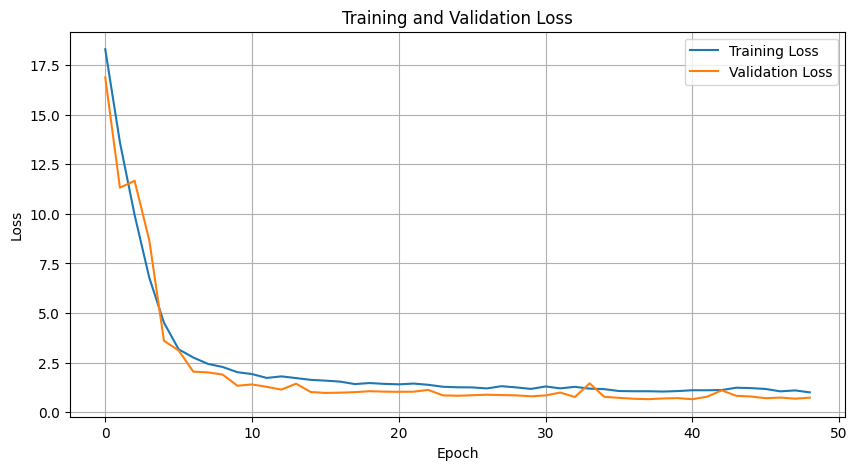

Model saved to 'v4_CNN_18fps.pth'

=== Testing model for 18fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 18fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 1.3868 degrees²
MAE: 0.6728 degrees
Predictions within 1°: 80.7%
Predictions within 3°: 96.5%
Predictions within 5°: 99.6%


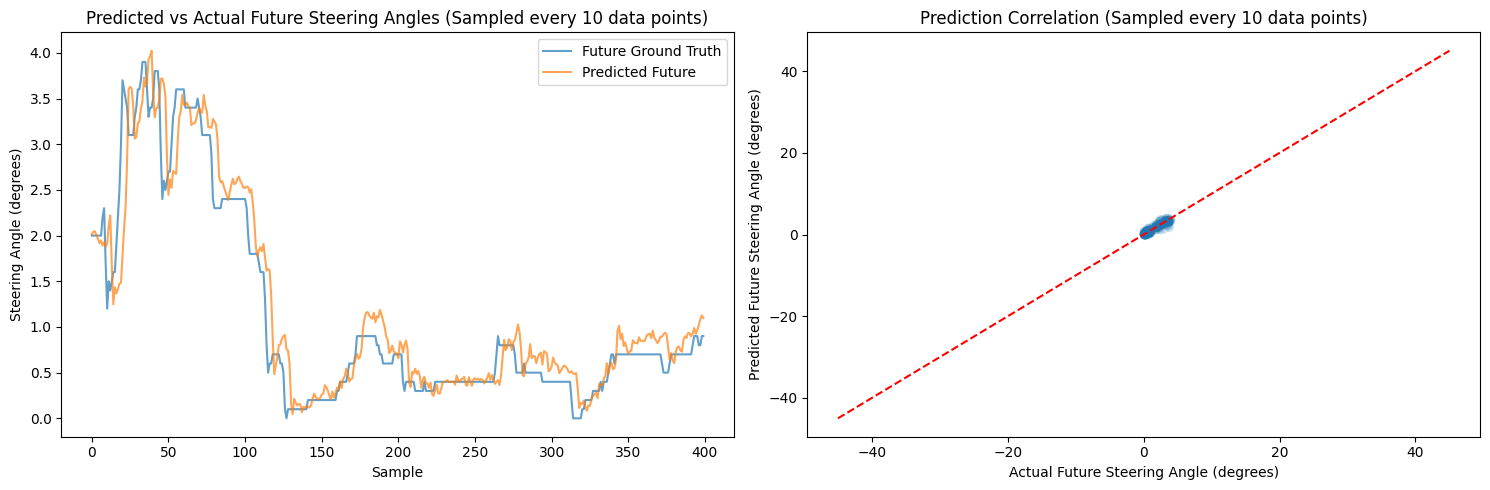

In [96]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 18  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")


=== Processing 20fps model ===

=== Training model for 20fps data ===
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
Detected high steering, skipping: /mnt/e/SteerNet/data_synced_20fps/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
Detected high steering, ski

Epoch 1/50: 100%|████████████████████████████████████████████| 17/17 [00:14<00:00,  1.18it/s, loss=5.943, gpu_mem=0.4GB]


Epoch 1: Train Loss: 19.0289, Val Loss: 20.6166


Epoch 2/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=6.080, gpu_mem=0.4GB]


Epoch 2: Train Loss: 15.0349, Val Loss: 14.3774


Epoch 3/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=4.605, gpu_mem=0.4GB]


Epoch 3: Train Loss: 10.8847, Val Loss: 10.4107


Epoch 4/50: 100%|████████████████████████████████████████████| 17/17 [00:06<00:00,  2.47it/s, loss=3.294, gpu_mem=0.4GB]


Epoch 4: Train Loss: 6.5626, Val Loss: 5.0578


Epoch 5/50: 100%|████████████████████████████████████████████| 17/17 [00:05<00:00,  2.96it/s, loss=1.836, gpu_mem=0.4GB]


Epoch 5: Train Loss: 3.9665, Val Loss: 3.0565


Epoch 6/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=1.055, gpu_mem=0.4GB]


Epoch 6: Train Loss: 2.6901, Val Loss: 3.4671


Epoch 7/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=1.058, gpu_mem=0.4GB]


Epoch 7: Train Loss: 2.2027, Val Loss: 1.4052


Epoch 8/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.839, gpu_mem=0.4GB]


Epoch 8: Train Loss: 1.7379, Val Loss: 1.1978


Epoch 9/50: 100%|████████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=1.071, gpu_mem=0.4GB]


Epoch 9: Train Loss: 1.7447, Val Loss: 1.3417


Epoch 10/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.19it/s, loss=1.095, gpu_mem=0.4GB]


Epoch 10: Train Loss: 1.7009, Val Loss: 1.4060


Epoch 11/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=1.062, gpu_mem=0.4GB]


Epoch 11: Train Loss: 1.4929, Val Loss: 1.3368


Epoch 12/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.00it/s, loss=1.952, gpu_mem=0.4GB]


Epoch 12: Train Loss: 1.6505, Val Loss: 1.3030


Epoch 13/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.756, gpu_mem=0.4GB]


Epoch 13: Train Loss: 1.6751, Val Loss: 1.4232


Epoch 14/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.790, gpu_mem=0.4GB]


Epoch 14: Train Loss: 1.5227, Val Loss: 1.4022


Epoch 15/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.87it/s, loss=0.775, gpu_mem=0.4GB]


Epoch 15: Train Loss: 1.4868, Val Loss: 1.2225


Epoch 16/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.25it/s, loss=0.642, gpu_mem=0.4GB]


Epoch 16: Train Loss: 1.3872, Val Loss: 1.1101


Epoch 17/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.786, gpu_mem=0.4GB]


Epoch 17: Train Loss: 1.2327, Val Loss: 1.1200


Epoch 18/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s, loss=0.777, gpu_mem=0.4GB]


Epoch 18: Train Loss: 1.4210, Val Loss: 1.0337


Epoch 19/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s, loss=0.710, gpu_mem=0.4GB]


Epoch 19: Train Loss: 1.3141, Val Loss: 1.6657


Epoch 20/50: 100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  3.05it/s, loss=0.578, gpu_mem=0.4GB]


Epoch 20: Train Loss: 1.2220, Val Loss: 1.0855


Epoch 21/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.45it/s, loss=0.726, gpu_mem=0.4GB]


Epoch 21: Train Loss: 1.1862, Val Loss: 0.9953


Epoch 22/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.546, gpu_mem=0.4GB]


Epoch 22: Train Loss: 1.1752, Val Loss: 1.0295


Epoch 23/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.686, gpu_mem=0.4GB]


Epoch 23: Train Loss: 1.1852, Val Loss: 1.0313


Epoch 24/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.27it/s, loss=0.694, gpu_mem=0.4GB]


Epoch 24: Train Loss: 1.1596, Val Loss: 1.0102


Epoch 25/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.520, gpu_mem=0.4GB]


Epoch 25: Train Loss: 1.1333, Val Loss: 0.8565


Epoch 26/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.63it/s, loss=0.375, gpu_mem=0.4GB]


Epoch 26: Train Loss: 1.1043, Val Loss: 1.0518


Epoch 27/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.551, gpu_mem=0.4GB]


Epoch 27: Train Loss: 1.1503, Val Loss: 0.9053


Epoch 28/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.837, gpu_mem=0.4GB]


Epoch 28: Train Loss: 1.1489, Val Loss: 1.1476


Epoch 29/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.666, gpu_mem=0.4GB]


Epoch 29: Train Loss: 1.1872, Val Loss: 1.1249


Epoch 30/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.435, gpu_mem=0.4GB]


Epoch 30: Train Loss: 1.2541, Val Loss: 1.0621


Epoch 31/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.498, gpu_mem=0.4GB]


Epoch 31: Train Loss: 1.1454, Val Loss: 0.7431


Epoch 32/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.555, gpu_mem=0.4GB]


Epoch 32: Train Loss: 1.1490, Val Loss: 0.7980


Epoch 33/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s, loss=0.438, gpu_mem=0.4GB]


Epoch 33: Train Loss: 1.0951, Val Loss: 0.8945


Epoch 34/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s, loss=1.094, gpu_mem=0.4GB]


Epoch 34: Train Loss: 1.1057, Val Loss: 0.7657


Epoch 35/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.35it/s, loss=0.740, gpu_mem=0.4GB]


Epoch 35: Train Loss: 1.1517, Val Loss: 0.8436


Epoch 36/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s, loss=0.411, gpu_mem=0.4GB]


Epoch 36: Train Loss: 1.0703, Val Loss: 0.7150


Epoch 37/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s, loss=0.531, gpu_mem=0.4GB]


Epoch 37: Train Loss: 1.0441, Val Loss: 0.7360


Epoch 38/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.43it/s, loss=0.547, gpu_mem=0.4GB]


Epoch 38: Train Loss: 0.9794, Val Loss: 0.7250


Epoch 39/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s, loss=0.757, gpu_mem=0.4GB]


Epoch 39: Train Loss: 1.1199, Val Loss: 0.6869


Epoch 40/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.31it/s, loss=1.249, gpu_mem=0.4GB]


Epoch 40: Train Loss: 1.1241, Val Loss: 0.7325


Epoch 41/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.384, gpu_mem=0.4GB]


Epoch 41: Train Loss: 0.9950, Val Loss: 0.7285


Epoch 42/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.439, gpu_mem=0.4GB]


Epoch 42: Train Loss: 1.0296, Val Loss: 0.6934


Epoch 43/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.70it/s, loss=0.508, gpu_mem=0.4GB]


Epoch 43: Train Loss: 1.1256, Val Loss: 0.7130


Epoch 44/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s, loss=0.387, gpu_mem=0.4GB]


Epoch 44: Train Loss: 1.0581, Val Loss: 0.6934


Epoch 45/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.469, gpu_mem=0.4GB]


Epoch 45: Train Loss: 1.0085, Val Loss: 0.6940


Epoch 46/50: 100%|███████████████████████████████████████████| 17/17 [00:06<00:00,  2.73it/s, loss=0.872, gpu_mem=0.4GB]


Epoch 46: Train Loss: 0.9947, Val Loss: 0.7147


Epoch 47/50: 100%|███████████████████████████████████████████| 17/17 [00:07<00:00,  2.29it/s, loss=0.650, gpu_mem=0.4GB]


Epoch 47: Train Loss: 1.0523, Val Loss: 0.7387
Early stopping triggered at epoch 47
Loaded best model from checkpoint


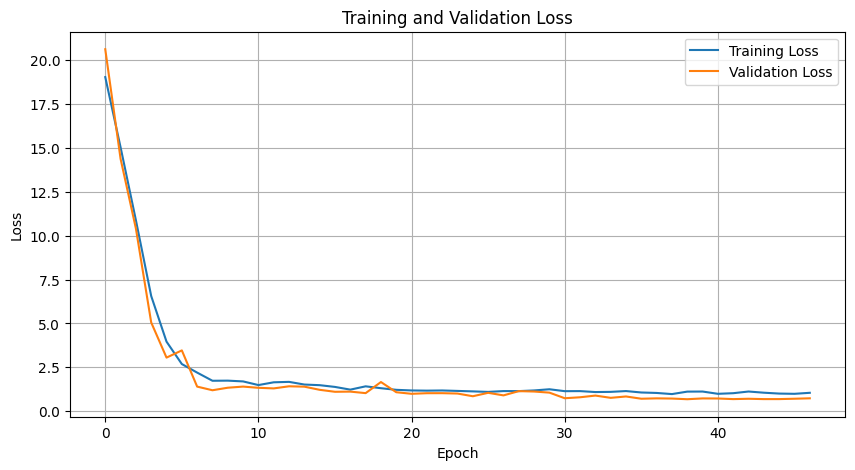

Model saved to 'v4_CNN_20fps.pth'

=== Testing model for 20fps data ===
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv
Detected high steering, skipping test file: /mnt/e/SteerNet/data_synced/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv

Test dataset summary for 20fps:
Total test frames: 87371

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.8359 degrees²
MAE: 0.5630 degrees
Predictions within 1°: 84.5%
Predictions within 3°: 98.8%
Predictions within 5°: 99.7%


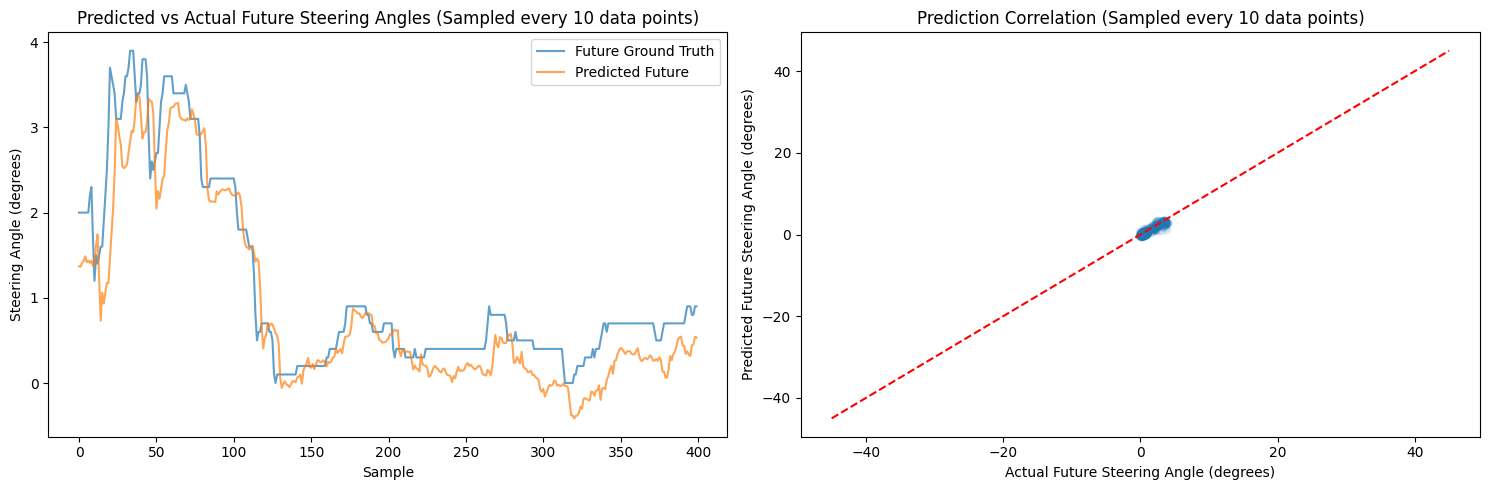

In [97]:
# Training and Testing block for each frame rate (run in separate cells)
fps = 20  # Change this for each frame rate
try:
    print(f"\n=== Processing {fps}fps model ===")
    
    # Train model
    model = train_model_for_fps(fps)
    if model is None:
        raise RuntimeError(f"Failed to train model for {fps}fps")
    
    # Test model
    metrics = test_model_for_fps(fps, model)
    if metrics is None:
        raise RuntimeError(f"Failed to test model for {fps}fps")
    
    # Final cleanup
    del model
    torch.cuda.empty_cache()
    gc.collect()
        
except Exception as e:
    print(f"Error processing {fps}fps model: {str(e)}")

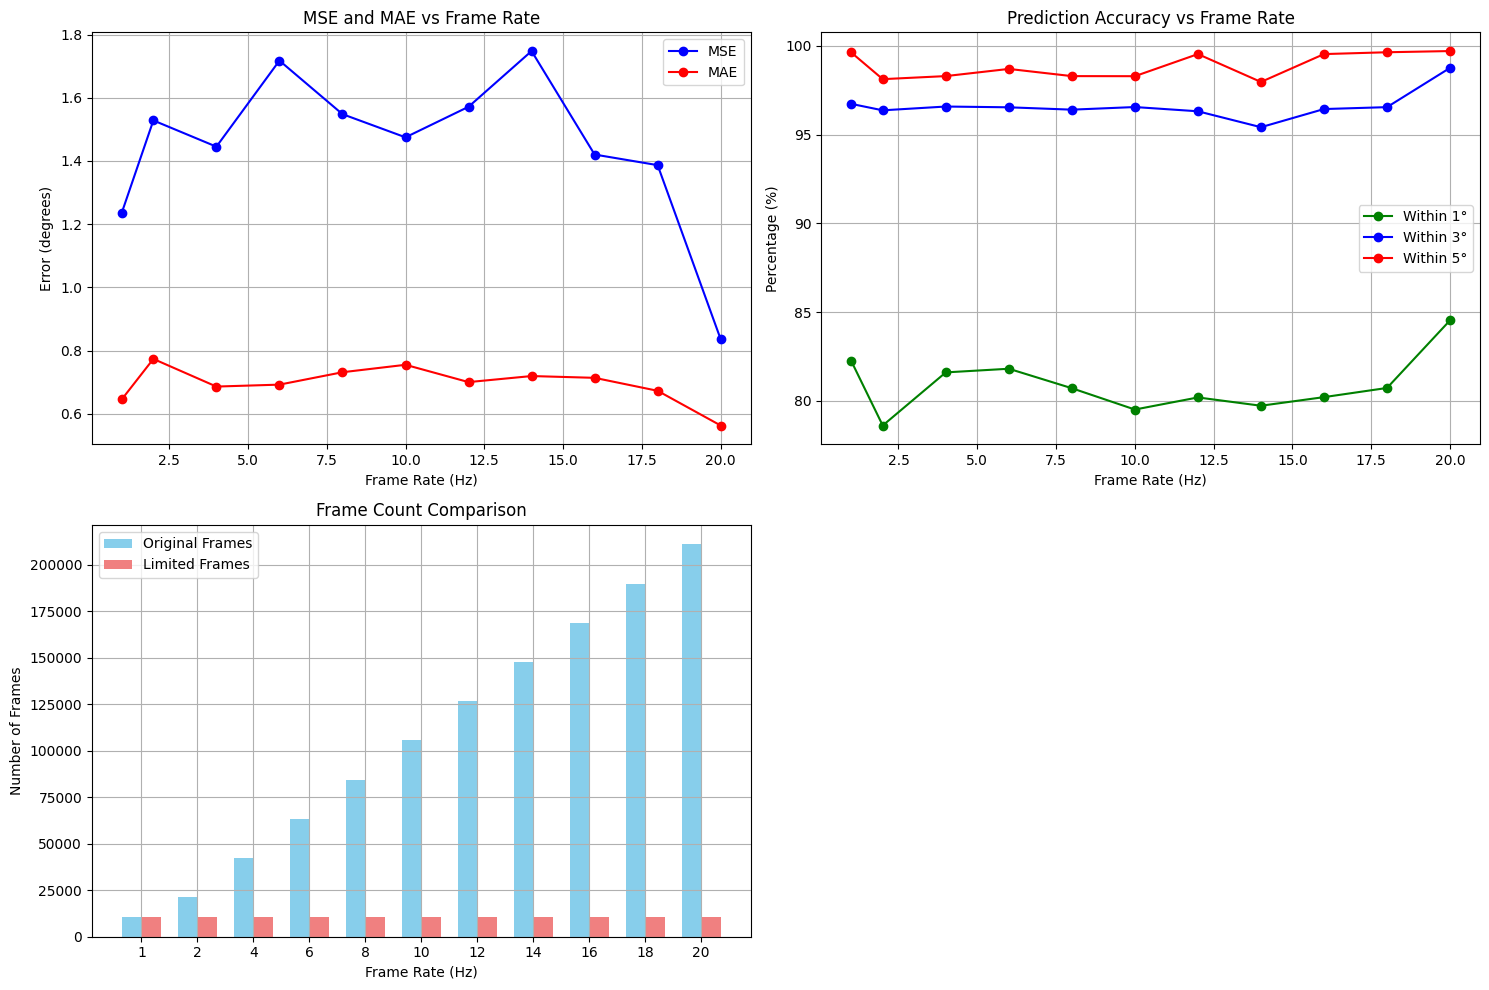


Numerical Results:

Frame Rate | Original Frames | Limited Frames | MSE | MAE | Within 1° | Within 3° | Within 5°
----------------------------------------------------------------------------------------------------
        1 |          10701 |         10701 |  1.24 |  0.65 |     82.2 |     96.7 |     99.6
        2 |          21238 |         10701 |  1.53 |  0.77 |     78.6 |     96.4 |     98.1
        4 |          42365 |         10701 |  1.45 |  0.69 |     81.6 |     96.6 |     98.3
        6 |          63466 |         10701 |  1.72 |  0.69 |     81.8 |     96.5 |     98.7
        8 |          84559 |         10701 |  1.55 |  0.73 |     80.7 |     96.4 |     98.3
       10 |         105650 |         10701 |  1.47 |  0.76 |     79.5 |     96.6 |     98.3
       12 |         126750 |         10701 |  1.57 |  0.70 |     80.2 |     96.3 |     99.5
       14 |         147806 |         10701 |  1.75 |  0.72 |     79.7 |     95.4 |     98.0
       16 |         168926 |         10701 |  1.

In [102]:
# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: MSE and MAE
plt.subplot(2, 2, 1)
x_values = frame_rates
mse_values = [results[fps]['mse'] for fps in frame_rates]
mae_values = [results[fps]['mae'] for fps in frame_rates]

valid_indices = [i for i, (mse, mae) in enumerate(zip(mse_values, mae_values)) 
                if not (np.isnan(mse) or np.isnan(mae))]
valid_fps = [frame_rates[i] for i in valid_indices]
valid_mse = [mse_values[i] for i in valid_indices]
valid_mae = [mae_values[i] for i in valid_indices]

plt.plot(valid_fps, valid_mse, 'b-o', label='MSE')
plt.plot(valid_fps, valid_mae, 'r-o', label='MAE')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Error (degrees)')
plt.title('MSE and MAE vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 2: Accuracy within degree thresholds
plt.subplot(2, 2, 2)
within_1_deg = [results[fps]['within_1_deg'] for fps in frame_rates]
within_3_deg = [results[fps]['within_3_deg'] for fps in frame_rates]
within_5_deg = [results[fps]['within_5_deg'] for fps in frame_rates]

valid_indices = [i for i, (w1, w3, w5) in enumerate(zip(within_1_deg, within_3_deg, within_5_deg)) 
                if not (np.isnan(w1) or np.isnan(w3) or np.isnan(w5))]
valid_fps = [frame_rates[i] for i in valid_indices]
valid_w1 = [within_1_deg[i] for i in valid_indices]
valid_w3 = [within_3_deg[i] for i in valid_indices]
valid_w5 = [within_5_deg[i] for i in valid_indices]

plt.plot(valid_fps, valid_w1, 'g-o', label='Within 1°')
plt.plot(valid_fps, valid_w3, 'b-o', label='Within 3°')
plt.plot(valid_fps, valid_w5, 'r-o', label='Within 5°')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Percentage (%)')
plt.title('Prediction Accuracy vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 3: Frame counts comparison
plt.subplot(2, 2, 3)
frames_before = [results[fps]['frames_before'] for fps in frame_rates]
frames_after = [results[fps]['frames_after'] for fps in frame_rates]

valid_indices = [i for i, (fb, fa) in enumerate(zip(frames_before, frames_after)) 
                if not (np.isnan(fb) or np.isnan(fa))]
x = np.arange(len(valid_indices))
width = 0.35

plt.bar(x - width/2, [frames_before[i] for i in valid_indices], 
        width, label='Original Frames', color='skyblue')
plt.bar(x + width/2, [frames_after[i] for i in valid_indices], 
        width, label='Limited Frames', color='lightcoral')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Number of Frames')
plt.title('Frame Count Comparison')
plt.xticks(x, [frame_rates[i] for i in valid_indices])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('frame_rate_comparison_fair.png')
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nFrame Rate | Original Frames | Limited Frames | MSE | MAE | Within 1° | Within 3° | Within 5°")
print("-" * 100)
for fps in frame_rates:
    data = results[fps]
    if not np.isnan(data['mse']):  # Check if we have valid data for this fps
        print(f"{fps:9d} | {int(data['frames_before']):14d} | {int(data['frames_after']):13d} | "
              f"{data['mse']:5.2f} | {data['mae']:5.2f} | "
              f"{data['within_1_deg']:8.1f} | {data['within_3_deg']:8.1f} | {data['within_5_deg']:8.1f}")
    else:
        print(f"{fps:9d} | {'Not Run':^14s} | {'Not Run':^13s} | {'N/A':^5s} | {'N/A':^5s} | "
              f"{'N/A':^8s} | {'N/A':^8s} | {'N/A':^8s}")